In [1]:
import json
import multiprocessing
import cv2
import albumentations as A
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import pandas as pd
import time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime
import math
import random

from timm.utils.model_ema import ModelEmaV2

# Config

In [2]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2


class CFG:
    # ============== comp exp name =============
    comp_name = 'atmacup_18'  # comp名

    comp_dataset_path = '../raw/atmacup_18_dataset/'

    exp_name = 'atmacup_18_cnn_swin_tiny'

    is_debug = False
    use_gray_scale = False

    model_in_chans = 9  # モデルの入力チャンネル数

    # ============== file path =============
    train_fold_dir = "../proc/baseline/folds"

    # ============== model cfg =============
    model_name = "swin_tiny_patch4_window7_224"

    num_frames = 3  # model_in_chansの倍数
    norm_in_chans = 1 if use_gray_scale else 3

    use_torch_compile = False
    use_ema = True
    ema_decay = 0.995
    # ============== training cfg =============
    size = 224  # 224

    batch_size = 64  # 32

    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 40
    if is_debug:
        epochs = 2

    # adamW warmupあり
    warmup_factor = 10
    lr = 1e-4
    if scheduler == 'GradualWarmupSchedulerV2':
        lr /= warmup_factor

    # ============== fold =============
    n_fold = 5
    use_holdout = False
    use_alldata = False
    train_folds = [0, 1, 2, 3, 4]

    skf_col = 'class'
    group_col = 'scene'
    fold_type = 'gkf'

    objective_cv = 'regression'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'minimize'  # 'maximize', 'minimize'
    metrics = 'calc_mae_atmacup'

    # ============== pred target =============
    target_size = 18
    target_col = ['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'x_2', 'y_2',
                  'z_2', 'x_3', 'y_3', 'z_3', 'x_4', 'y_4', 'z_4', 'x_5', 'y_5', 'z_5']


    # ============== ほぼ固定 =============
    pretrained = True
    inf_weight = 'last'  # 'best'

    min_lr = 1e-8
    weight_decay = 1e-5
    max_grad_norm = 1000

    print_freq = 500
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    if exp_name is not None:
        print('set dataset path')

        outputs_path = f'../proc/baseline/outputs/{exp_name}/'

        submission_dir = outputs_path + 'submissions/'
        submission_path = submission_dir + f'submission_{exp_name}.csv'

        model_dir = outputs_path + \
            f'{comp_name}-models/'

        figures_dir = outputs_path + 'figures/'

        log_dir = outputs_path + 'logs/'
        log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        # A.HorizontalFlip(p=0.5),
        # A.VerticalFlip(p=0.5),
        # A.RandomRotate90(p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
        # A.ShiftScaleRotate(p=0.5),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        # A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        # A.CoarseDropout(max_holes=1, max_height=int(
        #     size * 0.3), max_width=int(size * 0.3), p=0.5),

        A.Normalize(
            mean=[0] * norm_in_chans*num_frames,
            std=[1] * norm_in_chans*num_frames, 
        ),
        ToTensorV2(),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean=[0] * norm_in_chans*num_frames,
            std=[1] * norm_in_chans*num_frames,
        ),
        ToTensorV2(),
    ]

set dataset path


In [3]:
print("CUDA が利用可能か:", torch.cuda.is_available())
print("利用可能な CUDA デバイス数:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("現在の CUDA デバイス:", torch.cuda.get_device_name(0))

CUDA が利用可能か: True
利用可能な CUDA デバイス数: 1
現在の CUDA デバイス: NVIDIA GeForce RTX 3090


# make fold

In [4]:
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, StratifiedGroupKFold
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


def get_fold(train, cfg):
    if cfg.fold_type == 'kf':
        Fold = KFold(n_splits=cfg.n_fold,
                     shuffle=True, random_state=cfg.seed)
        kf = Fold.split(train, train[cfg.target_col])
    elif cfg.fold_type == 'skf':
        Fold = StratifiedKFold(n_splits=cfg.n_fold,
                               shuffle=True, random_state=cfg.seed)
        kf = Fold.split(train, train[cfg.skf_col])
    elif cfg.fold_type == 'gkf':
        Fold = GroupKFold(n_splits=cfg.n_fold)
        groups = train[cfg.group_col].values
        kf = Fold.split(train, train[cfg.group_col], groups)
    elif cfg.fold_type == 'sgkf':
        Fold = StratifiedGroupKFold(n_splits=cfg.n_fold,
                                    shuffle=True, random_state=cfg.seed)
        groups = train[cfg.group_col].values
        kf = Fold.split(train, train[cfg.skf_col], groups)
    # elif fold_type == 'mskf':
    #     Fold = MultilabelStratifiedKFold(
    #         n_splits=cfg.n_fold, shuffle=True, random_state=cfg.seed)
    #     kf = Fold.split(train, train[cfg.skf_col])

    for n, (train_index, val_index) in enumerate(kf):
        train.loc[val_index, 'fold'] = int(n)
    train['fold'] = train['fold'].astype(int)

    print(train.groupby('fold').size())

    return train

In [5]:
def make_train_folds():
    train_df = pd.read_csv(CFG.comp_dataset_path + 'train_features.csv')

    train_df['scene'] = train_df['ID'].str.split('_').str[0]

    print('group', CFG.group_col)
    print(f'train len: {len(train_df)}')

    train_df = get_fold(train_df, CFG)

    # print(train_df.groupby(['fold', CFG.target_col]).size())
    print(train_df['fold'].value_counts())

    os.makedirs(CFG.train_fold_dir, exist_ok=True)

    train_df.to_csv(CFG.train_fold_dir +
                    'train_folds.csv', index=False)

In [6]:
make_train_folds()

group scene
train len: 43371
fold
0    8675
1    8674
2    8674
3    8674
4    8674
dtype: int64
fold
0    8675
1    8674
2    8674
3    8674
4    8674
Name: count, dtype: int64


# setting

In [7]:
# 乱数固定
def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)

    if mode == 'train':
        make_dirs(cfg)

In [8]:
cfg_init(CFG)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# logger

In [10]:
# from common_utils.logger import init_logger, wandb_init, AverageMeter, timeSince
# from common_utils.settings import cfg_init

def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [11]:
Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------
2024年11月20日 22:37:04


# eval function

In [12]:
def get_score(y_true, y_pred):
    # return roc_auc_score(y_true, y_pred)
    eval_func = eval(CFG.metrics)
    return eval_func(y_true, y_pred)


def calc_mae_atmacup(y_true, y_pred):
    abs_diff = np.abs(y_true - y_pred)  # 各予測の差分の絶対値を計算して
    mae = np.mean(abs_diff.reshape(-1, ))  # 予測の差分の絶対値の平均を計算

    return mae

def get_result(result_df):

    # preds = result_df['preds'].values

    pred_cols = [f'pred_{i}' for i in range(CFG.target_size)]
    preds = result_df[pred_cols].values
    labels = result_df[CFG.target_col].values
    score = get_score(labels, preds)
    Logger.info(f'score: {score:<.4f}')

    return score

# image utils

In [13]:
def draw_traffic_light(image, id):
    path = f'./datasets/atmacup_18/traffic_lights/{id}.json'
    traffic_lights = json.load(open(path))

    traffic_class = ['green',
                     'straight', 'left', 'right', 'empty', 'other', 'yellow', 'red']
    class_to_idx = {
        cls: idx for idx, cls in enumerate(traffic_class)
    }

    for traffic_light in traffic_lights:
        bbox = traffic_light['bbox']
        x1, y1, x2, y2 = bbox
        # int
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        point1 = (x1, y1)
        point2 = (x2, y2)

        idx = class_to_idx[traffic_light['class']]
        color = 255 - int(255*(idx/len(traffic_class)))

        cv2.rectangle(image, point1, point2, color=color, thickness=1)

    return image


def read_image_for_cache(path):
    if CFG.use_gray_scale:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    else:
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # image = cv2.resize(image, (CFG.size, CFG.size))

    # 効かない
    # image = draw_traffic_light(image, path.split('/')[-2])
    return (path, image)


def make_video_cache(paths):
    debug = []
    for idx in range(9):
        color = 255 - int(255*(idx/9))
        debug.append(color)
    print(debug)

    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        res = pool.imap_unordered(read_image_for_cache, paths)
        res = tqdm(res)
        res = list(res)

    return dict(res)

# dataset

In [14]:
from albumentations import ReplayCompose
from torch.utils.data import DataLoader, Dataset
import albumentations as A

def get_transforms(data, cfg):
    if data == 'train':
        # aug = A.Compose(cfg.train_aug_list)
        aug = A.ReplayCompose(cfg.train_aug_list)
    elif data == 'valid':
        # aug = A.Compose(cfg.valid_aug_list)
        aug = A.ReplayCompose(cfg.valid_aug_list)

    # print(aug)
    return aug


class CustomDataset(Dataset):
    def __init__(self, df, cfg, labels=None, transform=None):
        self.df = df
        self.cfg = cfg
        self.base_paths = df['base_path'].values
        # self.labels = df[self.cfg.target_col].values
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def read_image_multiframe(self, idx):
        base_path = self.base_paths[idx]

        images = []
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix

            image = self.cfg.video_cache[path]

            images.append(image)
        return images

    def __getitem__(self, idx):
        image = self.read_image_multiframe(idx)

        if self.transform:
            # image = self.transform(image=image)['image']
            replay = None
            images = []
            for img in image:
                if replay is None:
                    sample = self.transform(image=img)
                    replay = sample['replay']
                else:
                    sample = ReplayCompose.replay(replay, image=img)
                images.append(sample['image'])

            image = torch.concat(images, dim=0)

        if self.labels is None:
            return image

        if self.cfg.objective_cv == 'multiclass':
            label = torch.tensor(self.labels[idx]).long()
        else:
            label = torch.tensor(self.labels[idx]).float()

        return image, label

In [15]:
def plot_aug_video(train, cfg, plot_count=1):
    transform = CFG.train_aug_list
    transform = A.ReplayCompose(transform)

    dataset = CustomDataset(
        train, CFG, transform=transform)

    for i in range(plot_count):
        image = dataset.read_image_multiframe(i)

        if cfg.use_gray_scale:
            image = np.stack(image, axis=2)
        else:
            image = np.concatenate(image, axis=2)

        aug_image = dataset[i]
        # torch to numpy
        aug_image = aug_image.permute(1, 2, 0).numpy()*255

        for frame in range(image.shape[-1]):
            if frame % 3 != 0:
                continue

            fig, axes = plt.subplots(1, 2, figsize=(15, 6))

            if cfg.use_gray_scale:
                axes[0].imshow(image[..., frame], cmap="gray")
                axes[1].imshow(aug_image[..., frame], cmap="gray")
            else:
                axes[0].imshow(image[..., frame:frame+3].astype(int))
                axes[1].imshow(aug_image[..., frame:frame+3].astype(int))
            plt.savefig(cfg.figures_dir +
                        f'aug_{i}_frame{frame}.png')

# model

In [16]:
import timm

class CustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False, target_size=None, model_name=None):
        super().__init__()
        # self.cfg = cfg

        if model_name is None:
            model_name = cfg.model_name

        print(f'pretrained: {pretrained}')

        self.model = timm.create_model(
            model_name, pretrained=pretrained, num_classes=0,
            in_chans=cfg.model_in_chans)

        # モデルの出力サイズを取得
        if hasattr(self.model, 'num_features'):
            self.n_features = self.model.num_features  # num_featuresで取得するモデルが多い
        elif hasattr(self.model, 'classifier') and hasattr(self.model.classifier, 'in_features'):
            self.n_features = self.model.classifier.in_features  # classifierが存在する場合
        elif hasattr(self.model, 'fc') and hasattr(self.model.fc, 'in_features'):
            self.n_features = self.model.fc.in_features  # fcが存在する場合
        else:
            raise AttributeError("Could not find the output feature size.")

        self.target_size = cfg.target_size if target_size is None else target_size

        # nn.Dropout(0.5),
        self.final_fc = nn.Sequential(
            nn.Linear(self.n_features, self.target_size)
        )

    def feature(self, image):

        feature = self.model(image)
        return feature

    def forward(self, image):
        feature = self.feature(image)
        output = self.final_fc(feature)
        return output

# scheduler

In [17]:
import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    if cfg.scheduler == 'ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(
            optimizer, mode='min', factor=cfg.factor, patience=cfg.patience, verbose=True, eps=cfg.eps)
    elif cfg.scheduler == 'CosineAnnealingLR':
        scheduler = CosineAnnealingLR(
            optimizer, T_max=cfg.epochs, eta_min=cfg.min_lr, last_epoch=-1)
    elif cfg.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(
            optimizer, T_0=cfg.T_0, T_mult=1, eta_min=cfg.min_lr, last_epoch=-1)
    elif cfg.scheduler == 'GradualWarmupSchedulerV2':
        scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, cfg.epochs, eta_min=1e-7)
        scheduler = GradualWarmupSchedulerV2(
            optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    if isinstance(scheduler, ReduceLROnPlateau):
        scheduler.step(avg_val_loss)
    elif isinstance(scheduler, CosineAnnealingLR):
        scheduler.step()
    elif isinstance(scheduler, CosineAnnealingWarmRestarts):
        scheduler.step()
    elif isinstance(scheduler, GradualWarmupSchedulerV2):
        scheduler.step(epoch)

# train

In [18]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device,
             model_ema=None):
    """ 1epoch毎のtrain """

    model.train()
    scaler = GradScaler(enabled=CFG.use_amp)

    losses = AverageMeter()
    preds = []
    preds_labels = []
    start = time.time()
    global_step = 0

    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)

            if y_preds.size(1) == 1:
                y_preds = y_preds.view(-1)

            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()

        if model_ema is not None:
            model_ema.update(model)

        optimizer.zero_grad()
        global_step += 1

        if CFG.objective_cv == 'binary':
            preds.append(torch.sigmoid(y_preds).detach().to('cpu').numpy())
        elif CFG.objective_cv == 'multiclass':
            preds.append(y_preds.softmax(1).detach().to('cpu').numpy())
        elif CFG.objective_cv == 'regression':
            preds.append(y_preds.detach().to('cpu').numpy())

        preds_labels.append(labels.detach().to('cpu').numpy())

        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.6f}  '
                  .format(epoch + 1, step, len(train_loader),
                          remain=timeSince(start, float(
                              step + 1) / len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
    predictions = np.concatenate(preds)
    labels = np.concatenate(preds_labels)
    return losses.avg, predictions, labels


def valid_fn(valid_loader, model, criterion, device):

    model.eval()
    losses = AverageMeter()
    preds = []
    start = time.time()

    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)

        if y_preds.size(1) == 1:
            y_preds = y_preds.view(-1)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # binary
        if CFG.objective_cv == 'binary':
            preds.append(torch.sigmoid(y_preds).to('cpu').numpy())
        elif CFG.objective_cv == 'multiclass':
            preds.append(y_preds.softmax(1).to('cpu').numpy())
        elif CFG.objective_cv == 'regression':
            preds.append(y_preds.to('cpu').numpy())

        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step + 1) / len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [19]:
def train_fold(folds, fold):

    Logger.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    if CFG.use_alldata:
        train_folds = folds.copy().reset_index(drop=True)
    else:
        train_folds = folds.loc[trn_idx].reset_index(drop=True)

    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    # train_folds = train_downsampling(train_folds)

    train_labels = train_folds[CFG.target_col].values
    valid_labels = valid_folds[CFG.target_col].values

    train_dataset = CustomDataset(
        train_folds, CFG, labels=train_labels, transform=get_transforms(data='train', cfg=CFG))
    valid_dataset = CustomDataset(
        valid_folds, CFG, labels=valid_labels, transform=get_transforms(data='valid', cfg=CFG))

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                              )
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================

    model = CustomModel(CFG, pretrained=CFG.pretrained)
    model.to(device)

    if CFG.use_ema:
        model_ema = ModelEmaV2(model, decay=CFG.ema_decay)
    else:
        model_ema = None

    optimizer = AdamW(model.parameters(), lr=CFG.lr)
    scheduler = get_scheduler(CFG, optimizer)

    # ====================================================
    # loop
    # ====================================================
    if CFG.objective_cv == 'binary':
        criterion = nn.BCEWithLogitsLoss()
    elif CFG.objective_cv == 'multiclass':
        criterion = nn.CrossEntropyLoss()
    elif CFG.objective_cv == 'regression':
        criterion = nn.L1Loss()

    if CFG.metric_direction == 'minimize':
        best_score = np.inf
    elif CFG.metric_direction == 'maximize':
        best_score = -1

    best_loss = np.inf

    df_score = pd.DataFrame(columns=["train_loss", 'train_score', 'val_loss', 'val_score'])

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss, train_preds, train_labels_epoch = train_fn(fold, train_loader, model,
                                                             criterion, optimizer, epoch, scheduler, device, model_ema)
        train_score = get_score(train_labels_epoch, train_preds)

        # eval
        if model_ema is not None:
            avg_val_loss, valid_preds = valid_fn(
                valid_loader, model_ema.module, criterion, device)
        else:
            avg_val_loss, valid_preds = valid_fn(
                valid_loader, model, criterion, device)

        scheduler_step(scheduler, avg_val_loss, epoch)

        # scoring
        score = get_score(valid_labels, valid_preds)

        elapsed = time.time() - start_time

        Logger.info(
            f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
        Logger.info(
            f'Epoch {epoch+1} - avg_train_Score: {train_score:.4f} avgScore: {score:.4f}')
        
        df_score.loc[epoch] = [avg_loss, train_score, avg_val_loss, score]

        if CFG.metric_direction == 'minimize':
            update_best = score < best_score
        elif CFG.metric_direction == 'maximize':
            update_best = score > best_score

        if update_best:
            best_loss = avg_val_loss
            best_score = score

            Logger.info(
                f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            Logger.info(
                f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')

            if model_ema is not None:
                torch.save({'model': model_ema.module.state_dict(),
                            'preds': valid_preds},
                           CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')
            else:
                torch.save({'model': model.state_dict(),
                            'preds': valid_preds},
                           CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

    """
    torch.save({'model': model.state_dict(),
                'preds': valid_preds},
               CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')
    """
    if model_ema is not None:
        torch.save({'model': model_ema.module.state_dict(),
                    'preds': valid_preds},
                   CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')
    else:
        torch.save({'model': model.state_dict(),
                    'preds': valid_preds},
                   CFG.model_dir + f'{CFG.model_name}_fold{fold}_last.pth')

    check_point = torch.load(
        CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))
    pred_cols = [f'pred_{i}' for i in range(CFG.target_size)]

    check_point_pred = check_point['preds']

    # Columns must be same length as key 対策
    if check_point_pred.ndim == 1:
        check_point_pred = check_point_pred.reshape(-1, CFG.target_size)

    print('check_point_pred shape', check_point_pred.shape)
    valid_folds[pred_cols] = check_point_pred
    return valid_folds, df_score

# train main

In [20]:
def main():
    train = pd.read_csv(CFG.train_fold_dir + 'train_folds.csv')
    train['ori_idx'] = train.index

    train['scene'] = train['ID'].str.split('_').str[0]

    """
    if CFG.is_debug:
        use_ids = train['scene'].unique()[:100]
        train = train[train['scene'].isin(use_ids)].reset_index(drop=True)
    """

    train['base_path'] = CFG.comp_dataset_path + 'images/' + train['ID'] + '/'

    paths = []
    for base_path in train['base_path'].values:
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix
            paths.append(path)

    print(paths[:5])

    CFG.video_cache = make_video_cache(paths)

    # plot_aug_video(train, CFG, plot_count=10)

    # train
    oof_df = pd.DataFrame()
    list_df_score = []
    for fold in range(CFG.n_fold):
        if fold not in CFG.train_folds:
            print(f'fold {fold} is skipped')
            continue

        _oof_df, _df_score = train_fold(train, fold)
        oof_df = pd.concat([oof_df, _oof_df])
        list_df_score.append(_df_score)
        Logger.info(f"========== fold: {fold} result ==========")
        get_result(_oof_df)

        if CFG.use_holdout or CFG.use_alldata:
            break

    oof_df = oof_df.sort_values('ori_idx').reset_index(drop=True)

    # CV result
    Logger.info("========== CV ==========")
    score = get_result(oof_df)

    # 学習曲線を可視化する
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.grid(alpha=0.1)
    ax2.grid(alpha=0.1)
    for i, df_score in enumerate(list_df_score):
        ax1.plot(df_score['train_score'], label=f'fold {i}')
        ax2.plot(df_score['val_score'], label=f'fold {i}')
    ax1.set_title('Train Score')
    ax2.set_title('Val Score') 
    ax1.set_xlabel('Epoch')
    ax2.set_xlabel('Epoch')
    ax1.set_ylabel('Train Score')
    ax2.set_ylabel('Val Score')
    plt.tight_layout()
    plt.savefig(CFG.figures_dir + f'learning_curve_{CFG.exp_name}.png')
    plt.show()

    # save result
    oof_df.to_csv(CFG.submission_dir + 'oof_cv.csv', index=False)

['../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t-1.0.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t-0.5.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_320/image_t.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_420/image_t-1.0.png', '../raw/atmacup_18_dataset/images/00066be8e20318869c38c66be466631a_420/image_t-0.5.png']
[255, 227, 199, 170, 142, 114, 85, 57, 29]


0it [00:00, ?it/s]

========== fold: 0 training ==========


pretrained: True


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 2s (remain 19m 50s) Loss: 5.4738(5.4738) Grad: 152745.0781  LR: 0.000010  
Epoch: [1][500/542] Elapsed 1m 4s (remain 0m 5s) Loss: 2.4769(3.0294) Grad: 100406.2969  LR: 0.000010  
Epoch: [1][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 2.6597(2.9668) Grad: 105888.2969  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 46s) Loss: 2.0497(2.0497) 
EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 2.5030(2.4345) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.9668  avg_val_loss: 2.4345  time: 82s
Epoch 1 - avg_train_Score: 2.9668 avgScore: 2.4345
Epoch 1 - Save Best Score: 2.4345 Model
Epoch 1 - Save Best Loss: 2.4345 Model
/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385

Epoch: [2][0/542] Elapsed 0m 1s (remain 10m 20s) Loss: 2.2208(2.2208) Grad: 1121492.7500  LR: 0.000010  
Epoch: [2][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 1.9393(1.9882) Grad: 131648.3906  LR: 0.000010  
Epoch: [2][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 1.3979(1.9783) Grad: 168941.1250  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 1.5640(1.5640) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.9783  avg_val_loss: 1.8766  time: 81s
Epoch 2 - avg_train_Score: 1.9783 avgScore: 1.8766
Epoch 2 - Save Best Score: 1.8766 Model
Epoch 2 - Save Best Loss: 1.8766 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 2.0217(1.8766) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 10m 8s) Loss: 1.7799(1.7799) Grad: 907624.0000  LR: 0.000100  
Epoch: [3][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 1.1624(1.5207) Grad: 36400.3672  LR: 0.000100  
Epoch: [3][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 1.2452(1.4936) Grad: 33310.5195  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 1.1632(1.1632) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.4936  avg_val_loss: 1.1390  time: 81s
Epoch 3 - avg_train_Score: 1.4936 avgScore: 1.1390
Epoch 3 - Save Best Score: 1.1390 Model
Epoch 3 - Save Best Loss: 1.1390 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.1797(1.1390) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 9m 56s) Loss: 1.0712(1.0712) Grad: 398719.5625  LR: 0.000100  
Epoch: [4][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.9874(0.9971) Grad: 239610.5312  LR: 0.000100  
Epoch: [4][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.9757(0.9934) Grad: 219179.0000  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 1.0215(1.0215) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 0.9934  avg_val_loss: 0.9802  time: 81s
Epoch 4 - avg_train_Score: 0.9934 avgScore: 0.9802
Epoch 4 - Save Best Score: 0.9802 Model
Epoch 4 - Save Best Loss: 0.9802 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.0194(0.9802) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 10m 12s) Loss: 1.0075(1.0075) Grad: 383345.9688  LR: 0.000099  
Epoch: [5][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 1.0157(0.8982) Grad: 233105.7812  LR: 0.000099  
Epoch: [5][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.8543(0.8976) Grad: 240374.0938  LR: 0.000099  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.9468(0.9468) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.8976  avg_val_loss: 0.9194  time: 81s
Epoch 5 - avg_train_Score: 0.8976 avgScore: 0.9194
Epoch 5 - Save Best Score: 0.9194 Model
Epoch 5 - Save Best Loss: 0.9194 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9414(0.9194) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 9m 26s) Loss: 0.9064(0.9064) Grad: 439721.6562  LR: 0.000098  
Epoch: [6][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.9099(0.8392) Grad: 269958.0938  LR: 0.000098  
Epoch: [6][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.9951(0.8391) Grad: 271163.5625  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.9266(0.9266) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.8391  avg_val_loss: 0.8843  time: 81s
Epoch 6 - avg_train_Score: 0.8391 avgScore: 0.8843
Epoch 6 - Save Best Score: 0.8843 Model
Epoch 6 - Save Best Loss: 0.8843 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8821(0.8843) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 10m 27s) Loss: 0.7544(0.7544) Grad: 353861.3750  LR: 0.000097  
Epoch: [7][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.9328(0.7872) Grad: 295092.5000  LR: 0.000097  
Epoch: [7][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.7071(0.7857) Grad: 277397.9375  LR: 0.000097  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.8650(0.8650) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.7857  avg_val_loss: 0.8585  time: 82s
Epoch 7 - avg_train_Score: 0.7857 avgScore: 0.8585
Epoch 7 - Save Best Score: 0.8585 Model
Epoch 7 - Save Best Loss: 0.8585 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8545(0.8585) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 9m 43s) Loss: 0.7050(0.7050) Grad: 606675.0625  LR: 0.000095  
Epoch: [8][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.7432(0.8018) Grad: 118222.0000  LR: 0.000095  
Epoch: [8][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.8562(0.8028) Grad: 178560.9688  LR: 0.000095  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.9070(0.9070) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.8028  avg_val_loss: 0.8402  time: 81s
Epoch 8 - avg_train_Score: 0.8028 avgScore: 0.8402
Epoch 8 - Save Best Score: 0.8402 Model
Epoch 8 - Save Best Loss: 0.8402 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8138(0.8402) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 9m 30s) Loss: 0.8722(0.8722) Grad: 789278.7500  LR: 0.000093  
Epoch: [9][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.6374(0.7002) Grad: 194751.9375  LR: 0.000093  
Epoch: [9][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5480(0.6992) Grad: 245735.7812  LR: 0.000093  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.8271(0.8271) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.6992  avg_val_loss: 0.8110  time: 81s
Epoch 9 - avg_train_Score: 0.6992 avgScore: 0.8110
Epoch 9 - Save Best Score: 0.8110 Model
Epoch 9 - Save Best Loss: 0.8110 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7206(0.8110) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 9m 45s) Loss: 0.5632(0.5632) Grad: 522129.9688  LR: 0.000091  
Epoch: [10][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.6335(0.6494) Grad: 206072.5312  LR: 0.000091  
Epoch: [10][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5876(0.6494) Grad: 186504.0156  LR: 0.000091  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.8430(0.8430) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.6494  avg_val_loss: 0.8020  time: 81s
Epoch 10 - avg_train_Score: 0.6494 avgScore: 0.8020
Epoch 10 - Save Best Score: 0.8020 Model
Epoch 10 - Save Best Loss: 0.8020 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7278(0.8020) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 10m 13s) Loss: 0.5618(0.5618) Grad: 436527.5000  LR: 0.000088  
Epoch: [11][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.7562(0.6725) Grad: 99206.6250  LR: 0.000088  
Epoch: [11][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5966(0.6745) Grad: 122562.6328  LR: 0.000088  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.8309(0.8309) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.6745  avg_val_loss: 0.7939  time: 81s
Epoch 11 - avg_train_Score: 0.6745 avgScore: 0.7939
Epoch 11 - Save Best Score: 0.7939 Model
Epoch 11 - Save Best Loss: 0.7939 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7275(0.7939) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 9m 54s) Loss: 0.5262(0.5262) Grad: 357731.5312  LR: 0.000086  
Epoch: [12][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.7220(0.5987) Grad: 208104.4375  LR: 0.000086  
Epoch: [12][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4660(0.5981) Grad: 125980.4531  LR: 0.000086  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.8014(0.8014) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.5981  avg_val_loss: 0.7751  time: 82s
Epoch 12 - avg_train_Score: 0.5981 avgScore: 0.7751
Epoch 12 - Save Best Score: 0.7751 Model
Epoch 12 - Save Best Loss: 0.7751 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6928(0.7751) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 9m 38s) Loss: 0.5070(0.5070) Grad: 308809.0000  LR: 0.000083  
Epoch: [13][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5305(0.5141) Grad: 325100.3750  LR: 0.000083  
Epoch: [13][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4586(0.5124) Grad: 348884.4375  LR: 0.000083  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.7920(0.7920) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.5124  avg_val_loss: 0.7657  time: 81s
Epoch 13 - avg_train_Score: 0.5124 avgScore: 0.7657
Epoch 13 - Save Best Score: 0.7657 Model
Epoch 13 - Save Best Loss: 0.7657 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6798(0.7657) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 9m 49s) Loss: 0.4408(0.4408) Grad: 351566.5000  LR: 0.000080  
Epoch: [14][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4429(0.5300) Grad: 149664.0781  LR: 0.000080  
Epoch: [14][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5422(0.5306) Grad: 204388.2031  LR: 0.000080  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.8053(0.8053) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.5306  avg_val_loss: 0.7636  time: 81s
Epoch 14 - avg_train_Score: 0.5306 avgScore: 0.7636
Epoch 14 - Save Best Score: 0.7636 Model
Epoch 14 - Save Best Loss: 0.7636 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6706(0.7636) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 9m 30s) Loss: 0.5978(0.5978) Grad: 338125.4375  LR: 0.000076  
Epoch: [15][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5040(0.5100) Grad: 190718.1250  LR: 0.000076  
Epoch: [15][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5867(0.5112) Grad: 203429.7188  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.7954(0.7954) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.5112  avg_val_loss: 0.7622  time: 81s
Epoch 15 - avg_train_Score: 0.5112 avgScore: 0.7622
Epoch 15 - Save Best Score: 0.7622 Model
Epoch 15 - Save Best Loss: 0.7622 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6517(0.7622) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 9m 32s) Loss: 0.5234(0.5234) Grad: 327931.3125  LR: 0.000073  
Epoch: [16][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4272(0.4590) Grad: 364204.5938  LR: 0.000073  
Epoch: [16][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4243(0.4587) Grad: 294684.9688  LR: 0.000073  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.7821(0.7821) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.4587  avg_val_loss: 0.7539  time: 81s
Epoch 16 - avg_train_Score: 0.4587 avgScore: 0.7539
Epoch 16 - Save Best Score: 0.7539 Model
Epoch 16 - Save Best Loss: 0.7539 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6676(0.7539) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 9m 54s) Loss: 0.3665(0.3665) Grad: 309889.1250  LR: 0.000069  
Epoch: [17][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4921(0.4644) Grad: 147657.1250  LR: 0.000069  
Epoch: [17][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5681(0.4682) Grad: 247277.7500  LR: 0.000069  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.8031(0.8031) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.4682  avg_val_loss: 0.7491  time: 81s
Epoch 17 - avg_train_Score: 0.4682 avgScore: 0.7491
Epoch 17 - Save Best Score: 0.7491 Model
Epoch 17 - Save Best Loss: 0.7491 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6646(0.7491) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 9m 30s) Loss: 0.4501(0.4501) Grad: 376642.0312  LR: 0.000066  
Epoch: [18][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4103(0.4340) Grad: 370884.9062  LR: 0.000066  
Epoch: [18][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4106(0.4346) Grad: 298567.7188  LR: 0.000066  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.7793(0.7793) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.4346  avg_val_loss: 0.7405  time: 81s
Epoch 18 - avg_train_Score: 0.4346 avgScore: 0.7405
Epoch 18 - Save Best Score: 0.7405 Model
Epoch 18 - Save Best Loss: 0.7405 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6610(0.7405) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 9m 28s) Loss: 0.4047(0.4047) Grad: 372197.5000  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4886(0.4016) Grad: 312669.7188  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4451(0.4028) Grad: 319593.2812  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.7745(0.7745) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.4028  avg_val_loss: 0.7367  time: 81s
Epoch 19 - avg_train_Score: 0.4028 avgScore: 0.7367
Epoch 19 - Save Best Score: 0.7367 Model
Epoch 19 - Save Best Loss: 0.7367 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6497(0.7367) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 9m 30s) Loss: 0.3857(0.3857) Grad: 286446.3125  LR: 0.000058  
Epoch: [20][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4080(0.4156) Grad: 212747.8750  LR: 0.000058  
Epoch: [20][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4238(0.4188) Grad: 167489.8750  LR: 0.000058  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.7720(0.7720) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.4188  avg_val_loss: 0.7367  time: 81s
Epoch 20 - avg_train_Score: 0.4188 avgScore: 0.7367


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6570(0.7367) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 9m 43s) Loss: 0.5115(0.5115) Grad: 417837.2188  LR: 0.000054  
Epoch: [21][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3923(0.3942) Grad: 318658.0000  LR: 0.000054  
Epoch: [21][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3518(0.3944) Grad: 256307.5938  LR: 0.000054  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 19s) Loss: 0.7557(0.7557) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.3944  avg_val_loss: 0.7331  time: 81s
Epoch 21 - avg_train_Score: 0.3944 avgScore: 0.7331
Epoch 21 - Save Best Score: 0.7331 Model
Epoch 21 - Save Best Loss: 0.7331 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6489(0.7331) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [22][0/542] Elapsed 0m 1s (remain 9m 46s) Loss: 0.3547(0.3547) Grad: 263824.1250  LR: 0.000050  
Epoch: [22][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3538(0.3640) Grad: 239193.0938  LR: 0.000050  
Epoch: [22][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3867(0.3648) Grad: 265979.4375  LR: 0.000050  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.7594(0.7594) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.3648  avg_val_loss: 0.7308  time: 81s
Epoch 22 - avg_train_Score: 0.3648 avgScore: 0.7308
Epoch 22 - Save Best Score: 0.7308 Model
Epoch 22 - Save Best Loss: 0.7308 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6522(0.7308) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [23][0/542] Elapsed 0m 1s (remain 10m 20s) Loss: 0.3381(0.3381) Grad: 276878.0938  LR: 0.000046  
Epoch: [23][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3465(0.3519) Grad: 266588.5000  LR: 0.000046  
Epoch: [23][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3022(0.3515) Grad: 269257.6250  LR: 0.000046  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.7479(0.7479) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.3515  avg_val_loss: 0.7293  time: 82s
Epoch 23 - avg_train_Score: 0.3515 avgScore: 0.7293
Epoch 23 - Save Best Score: 0.7293 Model
Epoch 23 - Save Best Loss: 0.7293 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6419(0.7293) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [24][0/542] Elapsed 0m 1s (remain 9m 36s) Loss: 0.3418(0.3418) Grad: 257677.0312  LR: 0.000043  
Epoch: [24][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3046(0.3424) Grad: 276205.9062  LR: 0.000043  
Epoch: [24][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2699(0.3421) Grad: 209160.1562  LR: 0.000043  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.7514(0.7514) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.3421  avg_val_loss: 0.7269  time: 81s
Epoch 24 - avg_train_Score: 0.3421 avgScore: 0.7269
Epoch 24 - Save Best Score: 0.7269 Model
Epoch 24 - Save Best Loss: 0.7269 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6490(0.7269) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 9m 32s) Loss: 0.3526(0.3526) Grad: 313732.8438  LR: 0.000039  
Epoch: [25][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3858(0.3314) Grad: 325756.4062  LR: 0.000039  
Epoch: [25][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2981(0.3311) Grad: 254395.3594  LR: 0.000039  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.7455(0.7455) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.3311  avg_val_loss: 0.7249  time: 81s
Epoch 25 - avg_train_Score: 0.3311 avgScore: 0.7249
Epoch 25 - Save Best Score: 0.7249 Model
Epoch 25 - Save Best Loss: 0.7249 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6579(0.7249) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [26][0/542] Elapsed 0m 1s (remain 9m 48s) Loss: 0.3342(0.3342) Grad: 266091.1562  LR: 0.000035  
Epoch: [26][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3400(0.3205) Grad: 338831.8750  LR: 0.000035  
Epoch: [26][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3305(0.3200) Grad: 285820.8125  LR: 0.000035  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.7536(0.7536) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.3200  avg_val_loss: 0.7238  time: 81s
Epoch 26 - avg_train_Score: 0.3200 avgScore: 0.7238
Epoch 26 - Save Best Score: 0.7238 Model
Epoch 26 - Save Best Loss: 0.7238 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6518(0.7238) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [27][0/542] Elapsed 0m 1s (remain 9m 31s) Loss: 0.2610(0.2610) Grad: 259976.7031  LR: 0.000031  
Epoch: [27][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3334(0.3086) Grad: 257687.7344  LR: 0.000031  
Epoch: [27][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2754(0.3088) Grad: 249181.0156  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 46s) Loss: 0.7471(0.7471) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.3088  avg_val_loss: 0.7228  time: 81s
Epoch 27 - avg_train_Score: 0.3088 avgScore: 0.7228
Epoch 27 - Save Best Score: 0.7228 Model
Epoch 27 - Save Best Loss: 0.7228 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6501(0.7228) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [28][0/542] Elapsed 0m 1s (remain 13m 24s) Loss: 0.3911(0.3911) Grad: 388932.1875  LR: 0.000028  
Epoch: [28][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3137(0.2977) Grad: 281411.2812  LR: 0.000028  
Epoch: [28][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.3571(0.2972) Grad: 300091.2812  LR: 0.000028  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.7503(0.7503) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.2972  avg_val_loss: 0.7235  time: 82s
Epoch 28 - avg_train_Score: 0.2972 avgScore: 0.7235


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6549(0.7235) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 9m 38s) Loss: 0.2925(0.2925) Grad: 277053.1250  LR: 0.000024  
Epoch: [29][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3792(0.2881) Grad: 287576.3438  LR: 0.000024  
Epoch: [29][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2345(0.2880) Grad: 216317.5312  LR: 0.000024  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.7469(0.7469) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.2880  avg_val_loss: 0.7209  time: 81s
Epoch 29 - avg_train_Score: 0.2880 avgScore: 0.7209
Epoch 29 - Save Best Score: 0.7209 Model
Epoch 29 - Save Best Loss: 0.7209 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6508(0.7209) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [30][0/542] Elapsed 0m 1s (remain 9m 50s) Loss: 0.2702(0.2702) Grad: 229552.6250  LR: 0.000021  
Epoch: [30][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3226(0.2795) Grad: 129668.4688  LR: 0.000021  
Epoch: [30][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2895(0.2807) Grad: 129717.6719  LR: 0.000021  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.7400(0.7400) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.2807  avg_val_loss: 0.7203  time: 81s
Epoch 30 - avg_train_Score: 0.2807 avgScore: 0.7203
Epoch 30 - Save Best Score: 0.7203 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6453(0.7203) 


Epoch 30 - Save Best Loss: 0.7203 Model
/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [31][0/542] Elapsed 0m 1s (remain 9m 41s) Loss: 0.2948(0.2948) Grad: 243886.2500  LR: 0.000018  
Epoch: [31][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2747(0.2716) Grad: 270135.6875  LR: 0.000018  
Epoch: [31][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2662(0.2715) Grad: 244370.7344  LR: 0.000018  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.7363(0.7363) 
EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6492(0.7197) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.2715  avg_val_loss: 0.7197  time: 81s
Epoch 31 - avg_train_Score: 0.2715 avgScore: 0.7197
Epoch 31 - Save Best Score: 0.7197 Model
Epoch 31 - Save Best Loss: 0.7197 Model
/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/278248

Epoch: [32][0/542] Elapsed 0m 1s (remain 10m 7s) Loss: 0.2836(0.2836) Grad: 239869.6562  LR: 0.000015  
Epoch: [32][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3086(0.2638) Grad: 230533.6562  LR: 0.000015  
Epoch: [32][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.2373(0.2633) Grad: 222938.1406  LR: 0.000015  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.7289(0.7289) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.2633  avg_val_loss: 0.7185  time: 82s
Epoch 32 - avg_train_Score: 0.2633 avgScore: 0.7185
Epoch 32 - Save Best Score: 0.7185 Model
Epoch 32 - Save Best Loss: 0.7185 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6527(0.7185) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [33][0/542] Elapsed 0m 1s (remain 9m 35s) Loss: 0.2264(0.2264) Grad: 267935.2188  LR: 0.000012  
Epoch: [33][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2501(0.2544) Grad: 246156.7656  LR: 0.000012  
Epoch: [33][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2336(0.2546) Grad: 209510.9531  LR: 0.000012  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.7404(0.7404) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.2546  avg_val_loss: 0.7180  time: 81s
Epoch 33 - avg_train_Score: 0.2546 avgScore: 0.7180
Epoch 33 - Save Best Score: 0.7180 Model
Epoch 33 - Save Best Loss: 0.7180 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6498(0.7180) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [34][0/542] Elapsed 0m 1s (remain 10m 1s) Loss: 0.2498(0.2498) Grad: 239957.7031  LR: 0.000010  
Epoch: [34][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2405(0.2484) Grad: 265631.5625  LR: 0.000010  
Epoch: [34][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2462(0.2488) Grad: 241825.9219  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.7374(0.7374) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.2488  avg_val_loss: 0.7169  time: 82s
Epoch 34 - avg_train_Score: 0.2488 avgScore: 0.7169
Epoch 34 - Save Best Score: 0.7169 Model
Epoch 34 - Save Best Loss: 0.7169 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6509(0.7169) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [35][0/542] Elapsed 0m 1s (remain 10m 4s) Loss: 0.2710(0.2710) Grad: 250604.5781  LR: 0.000008  
Epoch: [35][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2411(0.2424) Grad: 259460.1875  LR: 0.000008  
Epoch: [35][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2371(0.2422) Grad: 208104.5625  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.7390(0.7390) 
EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6540(0.7169) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.2422  avg_val_loss: 0.7169  time: 81s
Epoch 35 - avg_train_Score: 0.2422 avgScore: 0.7169
Epoch 35 - Save Best Score: 0.7169 Model
Epoch 35 - Save Best Loss: 0.7169 Model
/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/278248

Epoch: [36][0/542] Elapsed 0m 1s (remain 9m 32s) Loss: 0.2833(0.2833) Grad: 299121.3438  LR: 0.000006  
Epoch: [36][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.1756(0.2376) Grad: 210929.7344  LR: 0.000006  
Epoch: [36][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2118(0.2373) Grad: 241502.7812  LR: 0.000006  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 20s) Loss: 0.7419(0.7419) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.2373  avg_val_loss: 0.7167  time: 81s
Epoch 36 - avg_train_Score: 0.2373 avgScore: 0.7167
Epoch 36 - Save Best Score: 0.7167 Model
Epoch 36 - Save Best Loss: 0.7167 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6518(0.7167) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [37][0/542] Elapsed 0m 1s (remain 9m 51s) Loss: 0.2270(0.2270) Grad: 204809.0000  LR: 0.000004  
Epoch: [37][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2963(0.2343) Grad: 224873.9375  LR: 0.000004  
Epoch: [37][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.1962(0.2339) Grad: 291030.6562  LR: 0.000004  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.7423(0.7423) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.2339  avg_val_loss: 0.7161  time: 82s
Epoch 37 - avg_train_Score: 0.2339 avgScore: 0.7161
Epoch 37 - Save Best Score: 0.7161 Model
Epoch 37 - Save Best Loss: 0.7161 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6496(0.7161) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [38][0/542] Elapsed 0m 1s (remain 10m 0s) Loss: 0.2949(0.2949) Grad: 256380.2031  LR: 0.000003  
Epoch: [38][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2401(0.2295) Grad: 276540.3438  LR: 0.000003  
Epoch: [38][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2209(0.2296) Grad: 221781.9531  LR: 0.000003  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.7409(0.7409) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.2296  avg_val_loss: 0.7164  time: 81s
Epoch 38 - avg_train_Score: 0.2296 avgScore: 0.7164


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6509(0.7164) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 9m 57s) Loss: 0.2183(0.2183) Grad: 203898.9375  LR: 0.000002  
Epoch: [39][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2219(0.2276) Grad: 230589.9688  LR: 0.000002  
Epoch: [39][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2473(0.2272) Grad: 236551.0938  LR: 0.000002  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.7374(0.7374) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.2272  avg_val_loss: 0.7166  time: 81s
Epoch 39 - avg_train_Score: 0.2272 avgScore: 0.7166


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6534(0.7166) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [40][0/542] Elapsed 0m 1s (remain 9m 53s) Loss: 0.2368(0.2368) Grad: 230578.4375  LR: 0.000001  
Epoch: [40][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2875(0.2265) Grad: 121583.6797  LR: 0.000001  
Epoch: [40][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2419(0.2267) Grad: 99366.0000  LR: 0.000001  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 21s) Loss: 0.7381(0.7381) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.2267  avg_val_loss: 0.7160  time: 81s
Epoch 40 - avg_train_Score: 0.2267 avgScore: 0.7160
Epoch 40 - Save Best Score: 0.7160 Model
Epoch 40 - Save Best Loss: 0.7160 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6513(0.7160) 


/tmp/ipykernel_94354/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 0 result ==========
score: 0.7160
==========

check_point_pred shape (8675, 18)
pretrained: True


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 10m 30s) Loss: 6.3866(6.3866) Grad: 195029.8906  LR: 0.000010  
Epoch: [1][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 2.6612(3.1521) Grad: 96414.2500  LR: 0.000010  
Epoch: [1][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 2.2993(3.0871) Grad: 135119.0156  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 2.6699(2.6699) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 3.0871  avg_val_loss: 2.4627  time: 81s
Epoch 1 - avg_train_Score: 3.0871 avgScore: 2.4627
Epoch 1 - Save Best Score: 2.4627 Model
Epoch 1 - Save Best Loss: 2.4627 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.7218(2.4627) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 9m 56s) Loss: 1.9826(1.9826) Grad: inf  LR: 0.000010  
Epoch: [2][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 2.0495(2.0443) Grad: 116622.8906  LR: 0.000010  
Epoch: [2][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 1.9466(2.0244) Grad: 126414.2266  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 1.9835(1.9835) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 2.0244  avg_val_loss: 1.8426  time: 82s
Epoch 2 - avg_train_Score: 2.0244 avgScore: 1.8426
Epoch 2 - Save Best Score: 1.8426 Model
Epoch 2 - Save Best Loss: 1.8426 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.3550(1.8426) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 10m 39s) Loss: 1.4869(1.4869) Grad: inf  LR: 0.000100  
Epoch: [3][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 1.3856(1.4833) Grad: 48428.8984  LR: 0.000100  
Epoch: [3][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 1.2859(1.4601) Grad: 49516.9336  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 1.2363(1.2363) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.4601  avg_val_loss: 1.0952  time: 81s
Epoch 3 - avg_train_Score: 1.4601 avgScore: 1.0952
Epoch 3 - Save Best Score: 1.0952 Model
Epoch 3 - Save Best Loss: 1.0952 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.0243(1.0952) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 10m 8s) Loss: 1.3226(1.3226) Grad: 578431.0625  LR: 0.000100  
Epoch: [4][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 1.0703(1.0124) Grad: 141559.4688  LR: 0.000100  
Epoch: [4][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 1.1251(1.0087) Grad: 196694.3750  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.9980(0.9980) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.0087  avg_val_loss: 0.9663  time: 81s
Epoch 4 - avg_train_Score: 1.0087 avgScore: 0.9663
Epoch 4 - Save Best Score: 0.9663 Model
Epoch 4 - Save Best Loss: 0.9663 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8910(0.9663) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 10m 11s) Loss: 0.8895(0.8895) Grad: 457776.7812  LR: 0.000099  
Epoch: [5][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.9424(0.8893) Grad: 305142.8438  LR: 0.000099  
Epoch: [5][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.7182(0.8873) Grad: 198260.7969  LR: 0.000099  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.9160(0.9160) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.8873  avg_val_loss: 0.9008  time: 81s
Epoch 5 - avg_train_Score: 0.8873 avgScore: 0.9008
Epoch 5 - Save Best Score: 0.9008 Model
Epoch 5 - Save Best Loss: 0.9008 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8638(0.9008) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 10m 21s) Loss: 0.9290(0.9290) Grad: 443351.6875  LR: 0.000098  
Epoch: [6][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.8672(0.8287) Grad: 273427.1250  LR: 0.000098  
Epoch: [6][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.9172(0.8280) Grad: 243956.3750  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.8526(0.8526) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.8280  avg_val_loss: 0.8677  time: 82s
Epoch 6 - avg_train_Score: 0.8280 avgScore: 0.8677
Epoch 6 - Save Best Score: 0.8677 Model
Epoch 6 - Save Best Loss: 0.8677 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8396(0.8677) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 9m 52s) Loss: 0.8189(0.8189) Grad: inf  LR: 0.000097  
Epoch: [7][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.8247(0.7763) Grad: 230847.5000  LR: 0.000097  
Epoch: [7][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.7625(0.7770) Grad: 317058.5938  LR: 0.000097  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.8303(0.8303) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.7770  avg_val_loss: 0.8444  time: 81s
Epoch 7 - avg_train_Score: 0.7770 avgScore: 0.8444
Epoch 7 - Save Best Score: 0.8444 Model
Epoch 7 - Save Best Loss: 0.8444 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8113(0.8444) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 9m 59s) Loss: 0.8196(0.8196) Grad: 499205.0625  LR: 0.000095  
Epoch: [8][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.8053(0.7366) Grad: 228076.9219  LR: 0.000095  
Epoch: [8][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.7452(0.7378) Grad: 222806.9219  LR: 0.000095  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.8092(0.8092) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.7378  avg_val_loss: 0.8274  time: 81s
Epoch 8 - avg_train_Score: 0.7378 avgScore: 0.8274
Epoch 8 - Save Best Score: 0.8274 Model
Epoch 8 - Save Best Loss: 0.8274 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8377(0.8274) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 9m 53s) Loss: 0.7756(0.7756) Grad: 472109.6250  LR: 0.000093  
Epoch: [9][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5114(0.7034) Grad: 213563.8281  LR: 0.000093  
Epoch: [9][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.7562(0.7037) Grad: 272023.5938  LR: 0.000093  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.7811(0.7811) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.7037  avg_val_loss: 0.8129  time: 81s
Epoch 9 - avg_train_Score: 0.7037 avgScore: 0.8129
Epoch 9 - Save Best Score: 0.8129 Model
Epoch 9 - Save Best Loss: 0.8129 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8051(0.8129) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 9m 47s) Loss: 0.6537(0.6537) Grad: 475110.6250  LR: 0.000091  
Epoch: [10][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5283(0.6692) Grad: 218245.0000  LR: 0.000091  
Epoch: [10][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.7282(0.6709) Grad: 254910.7188  LR: 0.000091  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.8024(0.8024) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.6709  avg_val_loss: 0.8003  time: 81s
Epoch 10 - avg_train_Score: 0.6709 avgScore: 0.8003
Epoch 10 - Save Best Score: 0.8003 Model
Epoch 10 - Save Best Loss: 0.8003 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7984(0.8003) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 9m 53s) Loss: 0.7796(0.7796) Grad: 592860.9375  LR: 0.000088  
Epoch: [11][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.6557(0.6385) Grad: 245082.1250  LR: 0.000088  
Epoch: [11][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5748(0.6383) Grad: 284341.4375  LR: 0.000088  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.7656(0.7656) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.6383  avg_val_loss: 0.7919  time: 82s
Epoch 11 - avg_train_Score: 0.6383 avgScore: 0.7919
Epoch 11 - Save Best Score: 0.7919 Model
Epoch 11 - Save Best Loss: 0.7919 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7822(0.7919) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 10m 8s) Loss: 0.6900(0.6900) Grad: 465840.4375  LR: 0.000086  
Epoch: [12][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.7255(0.6082) Grad: 247022.9375  LR: 0.000086  
Epoch: [12][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5946(0.6095) Grad: 306546.3125  LR: 0.000086  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.7617(0.7617) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.6095  avg_val_loss: 0.7892  time: 81s
Epoch 12 - avg_train_Score: 0.6095 avgScore: 0.7892
Epoch 12 - Save Best Score: 0.7892 Model
Epoch 12 - Save Best Loss: 0.7892 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7865(0.7892) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 10m 53s) Loss: 0.6490(0.6490) Grad: 480588.0625  LR: 0.000083  
Epoch: [13][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5933(0.5914) Grad: 248250.9219  LR: 0.000083  
Epoch: [13][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5046(0.5905) Grad: 211834.6562  LR: 0.000083  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.7655(0.7655) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.5905  avg_val_loss: 0.7813  time: 81s
Epoch 13 - avg_train_Score: 0.5905 avgScore: 0.7813
Epoch 13 - Save Best Score: 0.7813 Model
Epoch 13 - Save Best Loss: 0.7813 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7835(0.7813) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 10m 14s) Loss: 0.5503(0.5503) Grad: 420237.9688  LR: 0.000080  
Epoch: [14][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.7120(0.5630) Grad: 214846.5156  LR: 0.000080  
Epoch: [14][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5062(0.5618) Grad: 184944.5000  LR: 0.000080  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.7518(0.7518) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.5618  avg_val_loss: 0.7706  time: 82s
Epoch 14 - avg_train_Score: 0.5618 avgScore: 0.7706
Epoch 14 - Save Best Score: 0.7706 Model
Epoch 14 - Save Best Loss: 0.7706 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7470(0.7706) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 10m 30s) Loss: 0.5430(0.5430) Grad: 540626.0000  LR: 0.000076  
Epoch: [15][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.6576(0.5112) Grad: 267277.9375  LR: 0.000076  
Epoch: [15][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4971(0.5134) Grad: 224028.3750  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7664(0.7664) 
EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7483(0.7602) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.5134  avg_val_loss: 0.7602  time: 81s
Epoch 15 - avg_train_Score: 0.5134 avgScore: 0.7602
Epoch 15 - Save Best Score: 0.7602 Model
Epoch 15 - Save Best Loss: 0.7602 Model
/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/278248

Epoch: [16][0/542] Elapsed 0m 1s (remain 10m 19s) Loss: 0.5817(0.5817) Grad: 322553.5625  LR: 0.000073  
Epoch: [16][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5355(0.4711) Grad: 302661.2500  LR: 0.000073  
Epoch: [16][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4516(0.4713) Grad: 364352.0625  LR: 0.000073  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7510(0.7510) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.4713  avg_val_loss: 0.7529  time: 82s
Epoch 16 - avg_train_Score: 0.4713 avgScore: 0.7529
Epoch 16 - Save Best Score: 0.7529 Model
Epoch 16 - Save Best Loss: 0.7529 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7510(0.7529) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 10m 15s) Loss: 0.4497(0.4497) Grad: 314423.2500  LR: 0.000069  
Epoch: [17][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4659(0.4795) Grad: 198546.6406  LR: 0.000069  
Epoch: [17][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4723(0.4815) Grad: 212961.2344  LR: 0.000069  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.7528(0.7528) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.4815  avg_val_loss: 0.7529  time: 81s
Epoch 17 - avg_train_Score: 0.4815 avgScore: 0.7529
Epoch 17 - Save Best Score: 0.7529 Model
Epoch 17 - Save Best Loss: 0.7529 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7350(0.7529) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 10m 2s) Loss: 0.4590(0.4590) Grad: 343676.8438  LR: 0.000066  
Epoch: [18][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4866(0.4663) Grad: 157722.7031  LR: 0.000066  
Epoch: [18][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4878(0.4666) Grad: 178766.0000  LR: 0.000066  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.7179(0.7179) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.4666  avg_val_loss: 0.7522  time: 81s
Epoch 18 - avg_train_Score: 0.4666 avgScore: 0.7522
Epoch 18 - Save Best Score: 0.7522 Model
Epoch 18 - Save Best Loss: 0.7522 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7224(0.7522) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 9m 57s) Loss: 0.4734(0.4734) Grad: 413656.2500  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4053(0.4188) Grad: 352211.5938  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4450(0.4199) Grad: 352936.5625  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.7426(0.7426) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.4199  avg_val_loss: 0.7462  time: 81s
Epoch 19 - avg_train_Score: 0.4199 avgScore: 0.7462
Epoch 19 - Save Best Score: 0.7462 Model
Epoch 19 - Save Best Loss: 0.7462 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7363(0.7462) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 10m 10s) Loss: 0.3672(0.3672) Grad: 312384.7500  LR: 0.000058  
Epoch: [20][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3891(0.4254) Grad: 162884.6250  LR: 0.000058  
Epoch: [20][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4428(0.4261) Grad: 162898.0938  LR: 0.000058  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.7371(0.7371) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.4261  avg_val_loss: 0.7467  time: 82s
Epoch 20 - avg_train_Score: 0.4261 avgScore: 0.7467


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7320(0.7467) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 10m 29s) Loss: 0.4376(0.4376) Grad: 308773.2188  LR: 0.000054  
Epoch: [21][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3839(0.3964) Grad: 317393.1250  LR: 0.000054  
Epoch: [21][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3755(0.3955) Grad: 286461.7500  LR: 0.000054  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.7195(0.7195) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.3955  avg_val_loss: 0.7412  time: 82s
Epoch 21 - avg_train_Score: 0.3955 avgScore: 0.7412
Epoch 21 - Save Best Score: 0.7412 Model
Epoch 21 - Save Best Loss: 0.7412 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7302(0.7412) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [22][0/542] Elapsed 0m 1s (remain 10m 50s) Loss: 0.4217(0.4217) Grad: 289625.1562  LR: 0.000050  
Epoch: [22][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3662(0.3653) Grad: 298917.4062  LR: 0.000050  
Epoch: [22][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4285(0.3658) Grad: 284237.5000  LR: 0.000050  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.7262(0.7262) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.3658  avg_val_loss: 0.7372  time: 82s
Epoch 22 - avg_train_Score: 0.3658 avgScore: 0.7372
Epoch 22 - Save Best Score: 0.7372 Model
Epoch 22 - Save Best Loss: 0.7372 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7131(0.7372) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [23][0/542] Elapsed 0m 1s (remain 10m 25s) Loss: 0.4014(0.4014) Grad: 328850.7188  LR: 0.000046  
Epoch: [23][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2798(0.3559) Grad: 269823.4688  LR: 0.000046  
Epoch: [23][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3127(0.3558) Grad: 282343.5938  LR: 0.000046  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.7276(0.7276) 
EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7249(0.7348) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.3558  avg_val_loss: 0.7348  time: 82s
Epoch 23 - avg_train_Score: 0.3558 avgScore: 0.7348
Epoch 23 - Save Best Score: 0.7348 Model
Epoch 23 - Save Best Loss: 0.7348 Model
/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/278248

Epoch: [24][0/542] Elapsed 0m 1s (remain 10m 7s) Loss: 0.3967(0.3967) Grad: 299639.9688  LR: 0.000043  
Epoch: [24][500/542] Elapsed 1m 4s (remain 0m 5s) Loss: 0.3697(0.3485) Grad: 309294.7812  LR: 0.000043  
Epoch: [24][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.2826(0.3477) Grad: 268211.9062  LR: 0.000043  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.7270(0.7270) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.3477  avg_val_loss: 0.7353  time: 82s
Epoch 24 - avg_train_Score: 0.3477 avgScore: 0.7353


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7173(0.7353) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 10m 5s) Loss: 0.3328(0.3328) Grad: 313079.5625  LR: 0.000039  
Epoch: [25][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3254(0.3349) Grad: 269441.3125  LR: 0.000039  
Epoch: [25][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2768(0.3346) Grad: 220525.4375  LR: 0.000039  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.7240(0.7240) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.3346  avg_val_loss: 0.7340  time: 82s
Epoch 25 - avg_train_Score: 0.3346 avgScore: 0.7340
Epoch 25 - Save Best Score: 0.7340 Model
Epoch 25 - Save Best Loss: 0.7340 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7244(0.7340) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [26][0/542] Elapsed 0m 1s (remain 10m 1s) Loss: 0.3452(0.3452) Grad: 276294.8750  LR: 0.000035  
Epoch: [26][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4292(0.3252) Grad: 307968.6250  LR: 0.000035  
Epoch: [26][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3172(0.3255) Grad: 288939.7188  LR: 0.000035  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.7285(0.7285) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.3255  avg_val_loss: 0.7306  time: 82s
Epoch 26 - avg_train_Score: 0.3255 avgScore: 0.7306
Epoch 26 - Save Best Score: 0.7306 Model
Epoch 26 - Save Best Loss: 0.7306 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7264(0.7306) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [27][0/542] Elapsed 0m 1s (remain 10m 46s) Loss: 0.3800(0.3800) Grad: 268793.4375  LR: 0.000031  
Epoch: [27][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2916(0.3147) Grad: 257306.5625  LR: 0.000031  
Epoch: [27][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2755(0.3150) Grad: 241072.1875  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.7246(0.7246) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.3150  avg_val_loss: 0.7278  time: 82s
Epoch 27 - avg_train_Score: 0.3150 avgScore: 0.7278
Epoch 27 - Save Best Score: 0.7278 Model
Epoch 27 - Save Best Loss: 0.7278 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7372(0.7278) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [28][0/542] Elapsed 0m 1s (remain 10m 5s) Loss: 0.3279(0.3279) Grad: 304059.4688  LR: 0.000028  
Epoch: [28][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3045(0.3023) Grad: 370106.8125  LR: 0.000028  
Epoch: [28][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3293(0.3026) Grad: 314822.7812  LR: 0.000028  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.7258(0.7258) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.3026  avg_val_loss: 0.7299  time: 82s
Epoch 28 - avg_train_Score: 0.3026 avgScore: 0.7299


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7457(0.7299) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 10m 4s) Loss: 0.3260(0.3260) Grad: 275254.2812  LR: 0.000024  
Epoch: [29][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2752(0.3087) Grad: 132701.8594  LR: 0.000024  
Epoch: [29][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3410(0.3083) Grad: 205727.9844  LR: 0.000024  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.7185(0.7185) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.3083  avg_val_loss: 0.7306  time: 82s
Epoch 29 - avg_train_Score: 0.3083 avgScore: 0.7306


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7162(0.7306) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [30][0/542] Elapsed 0m 1s (remain 10m 29s) Loss: 0.3699(0.3699) Grad: 379636.6562  LR: 0.000021  
Epoch: [30][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2876(0.2882) Grad: 279338.8438  LR: 0.000021  
Epoch: [30][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2493(0.2883) Grad: 211166.6406  LR: 0.000021  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.7262(0.7262) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.2883  avg_val_loss: 0.7285  time: 81s
Epoch 30 - avg_train_Score: 0.2883 avgScore: 0.7285


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7147(0.7285) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [31][0/542] Elapsed 0m 1s (remain 10m 31s) Loss: 0.2827(0.2827) Grad: 286398.1562  LR: 0.000018  
Epoch: [31][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2562(0.2749) Grad: 231956.6875  LR: 0.000018  
Epoch: [31][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.2365(0.2747) Grad: 259356.7500  LR: 0.000018  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.7321(0.7321) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.2747  avg_val_loss: 0.7275  time: 82s
Epoch 31 - avg_train_Score: 0.2747 avgScore: 0.7275
Epoch 31 - Save Best Score: 0.7275 Model
Epoch 31 - Save Best Loss: 0.7275 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7136(0.7275) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [32][0/542] Elapsed 0m 1s (remain 9m 49s) Loss: 0.2700(0.2700) Grad: 241212.9219  LR: 0.000015  
Epoch: [32][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2801(0.2666) Grad: 305031.7188  LR: 0.000015  
Epoch: [32][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2710(0.2668) Grad: 328434.4062  LR: 0.000015  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.7334(0.7334) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.2668  avg_val_loss: 0.7271  time: 81s
Epoch 32 - avg_train_Score: 0.2668 avgScore: 0.7271
Epoch 32 - Save Best Score: 0.7271 Model
Epoch 32 - Save Best Loss: 0.7271 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7152(0.7271) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [33][0/542] Elapsed 0m 1s (remain 10m 12s) Loss: 0.2345(0.2345) Grad: 237508.0625  LR: 0.000012  
Epoch: [33][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3071(0.2588) Grad: 242049.7500  LR: 0.000012  
Epoch: [33][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2283(0.2584) Grad: 263802.1875  LR: 0.000012  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.7320(0.7320) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.2584  avg_val_loss: 0.7266  time: 81s
Epoch 33 - avg_train_Score: 0.2584 avgScore: 0.7266
Epoch 33 - Save Best Score: 0.7266 Model
Epoch 33 - Save Best Loss: 0.7266 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7209(0.7266) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [34][0/542] Elapsed 0m 1s (remain 10m 41s) Loss: 0.2585(0.2585) Grad: 223884.8906  LR: 0.000010  
Epoch: [34][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2888(0.2529) Grad: 311061.9062  LR: 0.000010  
Epoch: [34][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2472(0.2525) Grad: 254321.7031  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.7303(0.7303) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.2525  avg_val_loss: 0.7255  time: 81s
Epoch 34 - avg_train_Score: 0.2525 avgScore: 0.7255
Epoch 34 - Save Best Score: 0.7255 Model
Epoch 34 - Save Best Loss: 0.7255 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7278(0.7255) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [35][0/542] Elapsed 0m 1s (remain 10m 35s) Loss: 0.2627(0.2627) Grad: 214573.2500  LR: 0.000008  
Epoch: [35][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.1854(0.2470) Grad: 205641.1094  LR: 0.000008  
Epoch: [35][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2284(0.2470) Grad: 246271.2656  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.7298(0.7298) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.2470  avg_val_loss: 0.7258  time: 81s
Epoch 35 - avg_train_Score: 0.2470 avgScore: 0.7258


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7241(0.7258) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [36][0/542] Elapsed 0m 1s (remain 12m 3s) Loss: 0.2852(0.2852) Grad: 242010.5781  LR: 0.000006  
Epoch: [36][500/542] Elapsed 1m 4s (remain 0m 5s) Loss: 0.2189(0.2422) Grad: 192923.3906  LR: 0.000006  
Epoch: [36][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.2608(0.2428) Grad: 288567.1562  LR: 0.000006  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.7272(0.7272) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.2428  avg_val_loss: 0.7239  time: 82s
Epoch 36 - avg_train_Score: 0.2428 avgScore: 0.7239
Epoch 36 - Save Best Score: 0.7239 Model
Epoch 36 - Save Best Loss: 0.7239 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7209(0.7239) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [37][0/542] Elapsed 0m 1s (remain 10m 2s) Loss: 0.1938(0.1938) Grad: 220874.2656  LR: 0.000004  
Epoch: [37][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2508(0.2386) Grad: 219733.2969  LR: 0.000004  
Epoch: [37][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2081(0.2384) Grad: 252550.9688  LR: 0.000004  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.7247(0.7247) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.2384  avg_val_loss: 0.7240  time: 82s
Epoch 37 - avg_train_Score: 0.2384 avgScore: 0.7240


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7172(0.7240) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [38][0/542] Elapsed 0m 1s (remain 10m 2s) Loss: 0.2074(0.2074) Grad: 221265.9062  LR: 0.000003  
Epoch: [38][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2300(0.2360) Grad: 238681.9062  LR: 0.000003  
Epoch: [38][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2389(0.2359) Grad: 277874.1562  LR: 0.000003  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 0.7248(0.7248) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.2359  avg_val_loss: 0.7234  time: 81s
Epoch 38 - avg_train_Score: 0.2359 avgScore: 0.7234
Epoch 38 - Save Best Score: 0.7234 Model
Epoch 38 - Save Best Loss: 0.7234 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7186(0.7234) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 10m 5s) Loss: 0.2427(0.2427) Grad: 329055.0625  LR: 0.000002  
Epoch: [39][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2302(0.2323) Grad: 204337.2344  LR: 0.000002  
Epoch: [39][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2303(0.2331) Grad: 218544.6250  LR: 0.000002  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.7247(0.7247) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.2331  avg_val_loss: 0.7235  time: 81s
Epoch 39 - avg_train_Score: 0.2331 avgScore: 0.7235


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7201(0.7235) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [40][0/542] Elapsed 0m 1s (remain 10m 7s) Loss: 0.2631(0.2631) Grad: 246328.9375  LR: 0.000001  
Epoch: [40][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2248(0.2313) Grad: 225908.1562  LR: 0.000001  
Epoch: [40][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2347(0.2316) Grad: 239958.3438  LR: 0.000001  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.7251(0.7251) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.2316  avg_val_loss: 0.7237  time: 82s
Epoch 40 - avg_train_Score: 0.2316 avgScore: 0.7237


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7204(0.7237) 


/tmp/ipykernel_94354/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 1 result ==========
score: 0.7237
==========

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 10m 13s) Loss: 4.5788(4.5788) Grad: 152290.8281  LR: 0.000010  
Epoch: [1][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 2.4102(3.0057) Grad: 81914.0703  LR: 0.000010  
Epoch: [1][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 2.5320(2.9495) Grad: 50214.2031  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 2.0493(2.0493) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.9495  avg_val_loss: 2.3169  time: 81s
Epoch 1 - avg_train_Score: 2.9495 avgScore: 2.3169
Epoch 1 - Save Best Score: 2.3169 Model
Epoch 1 - Save Best Loss: 2.3169 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 2.2411(2.3169) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 10m 16s) Loss: 2.2594(2.2594) Grad: inf  LR: 0.000010  
Epoch: [2][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 1.8148(1.9481) Grad: 41840.4297  LR: 0.000010  
Epoch: [2][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 1.7866(1.9284) Grad: 36173.2578  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 1.3949(1.3949) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.9284  avg_val_loss: 1.6988  time: 82s
Epoch 2 - avg_train_Score: 1.9284 avgScore: 1.6988
Epoch 2 - Save Best Score: 1.6988 Model
Epoch 2 - Save Best Loss: 1.6988 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.6267(1.6988) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 9m 57s) Loss: 1.7837(1.7837) Grad: inf  LR: 0.000100  
Epoch: [3][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 1.3057(1.5345) Grad: 17554.6602  LR: 0.000100  
Epoch: [3][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 1.1482(1.5105) Grad: 23900.8965  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.9212(0.9212) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.5105  avg_val_loss: 1.1070  time: 81s
Epoch 3 - avg_train_Score: 1.5105 avgScore: 1.1070
Epoch 3 - Save Best Score: 1.1070 Model
Epoch 3 - Save Best Loss: 1.1070 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.1017(1.1070) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 10m 6s) Loss: 1.1899(1.1899) Grad: inf  LR: 0.000100  
Epoch: [4][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.8682(1.0443) Grad: 107430.0469  LR: 0.000100  
Epoch: [4][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.9985(1.0379) Grad: 180304.7812  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.8871(0.8871) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.0379  avg_val_loss: 0.9944  time: 81s
Epoch 4 - avg_train_Score: 1.0379 avgScore: 0.9944
Epoch 4 - Save Best Score: 0.9944 Model
Epoch 4 - Save Best Loss: 0.9944 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9142(0.9944) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 10m 19s) Loss: 1.0285(1.0285) Grad: 656068.4375  LR: 0.000099  
Epoch: [5][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 1.0751(0.9399) Grad: 309700.4688  LR: 0.000099  
Epoch: [5][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.7739(0.9403) Grad: 166301.4531  LR: 0.000099  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.8621(0.8621) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.9403  avg_val_loss: 0.9557  time: 82s
Epoch 5 - avg_train_Score: 0.9403 avgScore: 0.9557
Epoch 5 - Save Best Score: 0.9557 Model
Epoch 5 - Save Best Loss: 0.9557 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8843(0.9557) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 10m 18s) Loss: 0.9005(0.9005) Grad: 507375.1250  LR: 0.000098  
Epoch: [6][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.9737(0.9171) Grad: 129563.8984  LR: 0.000098  
Epoch: [6][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 1.0288(0.9177) Grad: 139296.3438  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.8308(0.8308) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.9177  avg_val_loss: 0.9255  time: 82s
Epoch 6 - avg_train_Score: 0.9177 avgScore: 0.9255
Epoch 6 - Save Best Score: 0.9255 Model
Epoch 6 - Save Best Loss: 0.9255 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8588(0.9255) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 10m 4s) Loss: 0.8107(0.8107) Grad: 446502.3438  LR: 0.000097  
Epoch: [7][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 1.0304(0.8324) Grad: 131584.7188  LR: 0.000097  
Epoch: [7][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.8103(0.8341) Grad: 185459.2812  LR: 0.000097  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.8091(0.8091) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.8341  avg_val_loss: 0.8813  time: 81s
Epoch 7 - avg_train_Score: 0.8341 avgScore: 0.8813
Epoch 7 - Save Best Score: 0.8813 Model
Epoch 7 - Save Best Loss: 0.8813 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8241(0.8813) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 10m 30s) Loss: 0.8255(0.8255) Grad: 553959.6875  LR: 0.000095  
Epoch: [8][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.7055(0.7728) Grad: 279716.1562  LR: 0.000095  
Epoch: [8][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.7158(0.7723) Grad: 293602.3438  LR: 0.000095  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.7611(0.7611) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.7723  avg_val_loss: 0.8513  time: 82s
Epoch 8 - avg_train_Score: 0.7723 avgScore: 0.8513
Epoch 8 - Save Best Score: 0.8513 Model
Epoch 8 - Save Best Loss: 0.8513 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8117(0.8513) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 11m 38s) Loss: 0.5980(0.5980) Grad: inf  LR: 0.000093  
Epoch: [9][500/542] Elapsed 1m 4s (remain 0m 5s) Loss: 0.6695(0.7738) Grad: 127371.6406  LR: 0.000093  
Epoch: [9][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.8034(0.7770) Grad: 122035.7344  LR: 0.000093  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.7631(0.7631) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.7770  avg_val_loss: 0.8411  time: 82s
Epoch 9 - avg_train_Score: 0.7770 avgScore: 0.8411
Epoch 9 - Save Best Score: 0.8411 Model
Epoch 9 - Save Best Loss: 0.8411 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7852(0.8411) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 11m 11s) Loss: 0.7274(0.7274) Grad: 561278.1250  LR: 0.000091  
Epoch: [10][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.6295(0.6976) Grad: 143331.7500  LR: 0.000091  
Epoch: [10][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.9801(0.7012) Grad: 141410.9531  LR: 0.000091  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.7453(0.7453) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.7012  avg_val_loss: 0.8192  time: 82s
Epoch 10 - avg_train_Score: 0.7012 avgScore: 0.8192
Epoch 10 - Save Best Score: 0.8192 Model
Epoch 10 - Save Best Loss: 0.8192 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7817(0.8192) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 9m 58s) Loss: 0.6251(0.6251) Grad: 592494.1250  LR: 0.000088  
Epoch: [11][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.8337(0.7108) Grad: 191000.2031  LR: 0.000088  
Epoch: [11][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6344(0.7108) Grad: 163067.2812  LR: 0.000088  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.7350(0.7350) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.7108  avg_val_loss: 0.8061  time: 81s
Epoch 11 - avg_train_Score: 0.7108 avgScore: 0.8061
Epoch 11 - Save Best Score: 0.8061 Model
Epoch 11 - Save Best Loss: 0.8061 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7611(0.8061) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 10m 22s) Loss: 0.7162(0.7162) Grad: 671118.8750  LR: 0.000086  
Epoch: [12][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5841(0.6383) Grad: 266266.5625  LR: 0.000086  
Epoch: [12][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6380(0.6394) Grad: 236741.9375  LR: 0.000086  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.7087(0.7087) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.6394  avg_val_loss: 0.7881  time: 81s
Epoch 12 - avg_train_Score: 0.6394 avgScore: 0.7881
Epoch 12 - Save Best Score: 0.7881 Model
Epoch 12 - Save Best Loss: 0.7881 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7518(0.7881) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 11m 3s) Loss: 0.5861(0.5861) Grad: 513968.5000  LR: 0.000083  
Epoch: [13][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.6207(0.6060) Grad: 218815.3750  LR: 0.000083  
Epoch: [13][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6494(0.6070) Grad: 207240.9688  LR: 0.000083  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.7185(0.7185) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.6070  avg_val_loss: 0.7806  time: 82s
Epoch 13 - avg_train_Score: 0.6070 avgScore: 0.7806
Epoch 13 - Save Best Score: 0.7806 Model
Epoch 13 - Save Best Loss: 0.7806 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7531(0.7806) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 10m 47s) Loss: 0.6272(0.6272) Grad: 457900.8750  LR: 0.000080  
Epoch: [14][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5908(0.5760) Grad: 237698.6719  LR: 0.000080  
Epoch: [14][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.4692(0.5796) Grad: 189545.7500  LR: 0.000080  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.7148(0.7148) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.5796  avg_val_loss: 0.7795  time: 82s
Epoch 14 - avg_train_Score: 0.5796 avgScore: 0.7795
Epoch 14 - Save Best Score: 0.7795 Model
Epoch 14 - Save Best Loss: 0.7795 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7318(0.7795) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 11m 6s) Loss: 0.5865(0.5865) Grad: 548783.6875  LR: 0.000076  
Epoch: [15][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5747(0.5603) Grad: 268982.3125  LR: 0.000076  
Epoch: [15][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6001(0.5601) Grad: 211420.0625  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.6870(0.6870) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.5601  avg_val_loss: 0.7722  time: 82s
Epoch 15 - avg_train_Score: 0.5601 avgScore: 0.7722
Epoch 15 - Save Best Score: 0.7722 Model
Epoch 15 - Save Best Loss: 0.7722 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7308(0.7722) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 10m 22s) Loss: 0.6097(0.6097) Grad: 498777.5312  LR: 0.000073  
Epoch: [16][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5772(0.5407) Grad: 260668.6094  LR: 0.000073  
Epoch: [16][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6054(0.5422) Grad: 202402.0469  LR: 0.000073  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.6947(0.6947) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.5422  avg_val_loss: 0.7616  time: 81s
Epoch 16 - avg_train_Score: 0.5422 avgScore: 0.7616
Epoch 16 - Save Best Score: 0.7616 Model
Epoch 16 - Save Best Loss: 0.7616 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7109(0.7616) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 10m 36s) Loss: 0.4100(0.4100) Grad: 354339.4062  LR: 0.000069  
Epoch: [17][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5572(0.5276) Grad: 231976.7344  LR: 0.000069  
Epoch: [17][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.4241(0.5296) Grad: 247320.2344  LR: 0.000069  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.6822(0.6822) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.5296  avg_val_loss: 0.7619  time: 82s
Epoch 17 - avg_train_Score: 0.5296 avgScore: 0.7619


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7286(0.7619) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 10m 28s) Loss: 0.4423(0.4423) Grad: 433337.5625  LR: 0.000066  
Epoch: [18][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5639(0.4781) Grad: 237345.3594  LR: 0.000066  
Epoch: [18][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4707(0.4786) Grad: 194053.5469  LR: 0.000066  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.6902(0.6902) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.4786  avg_val_loss: 0.7558  time: 81s
Epoch 18 - avg_train_Score: 0.4786 avgScore: 0.7558
Epoch 18 - Save Best Score: 0.7558 Model
Epoch 18 - Save Best Loss: 0.7558 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7256(0.7558) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 10m 7s) Loss: 0.5324(0.5324) Grad: 402310.2812  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5187(0.4882) Grad: 225700.2031  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6001(0.4889) Grad: 127607.5938  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.6779(0.6779) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.4889  avg_val_loss: 0.7497  time: 82s
Epoch 19 - avg_train_Score: 0.4889 avgScore: 0.7497
Epoch 19 - Save Best Score: 0.7497 Model
Epoch 19 - Save Best Loss: 0.7497 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7219(0.7497) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 10m 22s) Loss: 0.4757(0.4757) Grad: 454469.8438  LR: 0.000058  
Epoch: [20][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4098(0.4366) Grad: 358207.4375  LR: 0.000058  
Epoch: [20][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4007(0.4359) Grad: 367900.7500  LR: 0.000058  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.6749(0.6749) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.4359  avg_val_loss: 0.7452  time: 82s
Epoch 20 - avg_train_Score: 0.4359 avgScore: 0.7452
Epoch 20 - Save Best Score: 0.7452 Model
Epoch 20 - Save Best Loss: 0.7452 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7178(0.7452) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 10m 31s) Loss: 0.4290(0.4290) Grad: 322938.2500  LR: 0.000054  
Epoch: [21][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4139(0.4066) Grad: 332570.3438  LR: 0.000054  
Epoch: [21][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.3788(0.4068) Grad: 288712.5312  LR: 0.000054  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.6742(0.6742) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.4068  avg_val_loss: 0.7416  time: 82s
Epoch 21 - avg_train_Score: 0.4068 avgScore: 0.7416
Epoch 21 - Save Best Score: 0.7416 Model
Epoch 21 - Save Best Loss: 0.7416 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7047(0.7416) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [22][0/542] Elapsed 0m 1s (remain 10m 9s) Loss: 0.4060(0.4060) Grad: 324953.8750  LR: 0.000050  
Epoch: [22][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3720(0.3963) Grad: 333134.9062  LR: 0.000050  
Epoch: [22][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3500(0.3961) Grad: 340412.7812  LR: 0.000050  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.6867(0.6867) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.3961  avg_val_loss: 0.7419  time: 82s
Epoch 22 - avg_train_Score: 0.3961 avgScore: 0.7419


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7039(0.7419) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [23][0/542] Elapsed 0m 1s (remain 10m 10s) Loss: 0.3668(0.3668) Grad: 332131.0312  LR: 0.000046  
Epoch: [23][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3645(0.3861) Grad: 307599.1562  LR: 0.000046  
Epoch: [23][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3631(0.3857) Grad: 386526.7812  LR: 0.000046  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.6845(0.6845) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.3857  avg_val_loss: 0.7360  time: 81s
Epoch 23 - avg_train_Score: 0.3857 avgScore: 0.7360
Epoch 23 - Save Best Score: 0.7360 Model
Epoch 23 - Save Best Loss: 0.7360 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6955(0.7360) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [24][0/542] Elapsed 0m 1s (remain 10m 41s) Loss: 0.3759(0.3759) Grad: 334901.5938  LR: 0.000043  
Epoch: [24][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4629(0.4092) Grad: 168582.2656  LR: 0.000043  
Epoch: [24][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3992(0.4089) Grad: 177269.3594  LR: 0.000043  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.6641(0.6641) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.4089  avg_val_loss: 0.7387  time: 82s
Epoch 24 - avg_train_Score: 0.4089 avgScore: 0.7387


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6874(0.7387) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 10m 20s) Loss: 0.3421(0.3421) Grad: 330726.0938  LR: 0.000039  
Epoch: [25][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3561(0.3746) Grad: 292672.1250  LR: 0.000039  
Epoch: [25][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3541(0.3743) Grad: 296218.8125  LR: 0.000039  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.6682(0.6682) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.3743  avg_val_loss: 0.7341  time: 82s
Epoch 25 - avg_train_Score: 0.3743 avgScore: 0.7341
Epoch 25 - Save Best Score: 0.7341 Model
Epoch 25 - Save Best Loss: 0.7341 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6932(0.7341) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [26][0/542] Elapsed 0m 1s (remain 10m 34s) Loss: 0.3306(0.3306) Grad: 351242.1250  LR: 0.000035  
Epoch: [26][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3419(0.3482) Grad: 308995.3125  LR: 0.000035  
Epoch: [26][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3208(0.3483) Grad: 304602.9688  LR: 0.000035  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.6553(0.6553) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.3483  avg_val_loss: 0.7312  time: 81s
Epoch 26 - avg_train_Score: 0.3483 avgScore: 0.7312
Epoch 26 - Save Best Score: 0.7312 Model
Epoch 26 - Save Best Loss: 0.7312 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6936(0.7312) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [27][0/542] Elapsed 0m 1s (remain 10m 13s) Loss: 0.3554(0.3554) Grad: 288496.5312  LR: 0.000031  
Epoch: [27][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3215(0.3354) Grad: 235680.3125  LR: 0.000031  
Epoch: [27][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3332(0.3354) Grad: 277659.7500  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.6550(0.6550) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.3354  avg_val_loss: 0.7285  time: 82s
Epoch 27 - avg_train_Score: 0.3354 avgScore: 0.7285
Epoch 27 - Save Best Score: 0.7285 Model
Epoch 27 - Save Best Loss: 0.7285 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6931(0.7285) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [28][0/542] Elapsed 0m 1s (remain 10m 23s) Loss: 0.2823(0.2823) Grad: 251143.9531  LR: 0.000028  
Epoch: [28][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2886(0.3240) Grad: 275659.5312  LR: 0.000028  
Epoch: [28][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3321(0.3238) Grad: 313469.5312  LR: 0.000028  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.6683(0.6683) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.3238  avg_val_loss: 0.7279  time: 82s
Epoch 28 - avg_train_Score: 0.3238 avgScore: 0.7279
Epoch 28 - Save Best Score: 0.7279 Model
Epoch 28 - Save Best Loss: 0.7279 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7038(0.7279) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 9m 56s) Loss: 0.2982(0.2982) Grad: 280782.4062  LR: 0.000024  
Epoch: [29][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3045(0.3159) Grad: 273623.1250  LR: 0.000024  
Epoch: [29][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.3000(0.3154) Grad: 285477.7812  LR: 0.000024  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.6506(0.6506) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.3154  avg_val_loss: 0.7273  time: 82s
Epoch 29 - avg_train_Score: 0.3154 avgScore: 0.7273
Epoch 29 - Save Best Score: 0.7273 Model
Epoch 29 - Save Best Loss: 0.7273 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6989(0.7273) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [30][0/542] Elapsed 0m 1s (remain 9m 59s) Loss: 0.3376(0.3376) Grad: 336760.2500  LR: 0.000021  
Epoch: [30][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4021(0.3037) Grad: 343949.3438  LR: 0.000021  
Epoch: [30][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2865(0.3045) Grad: 264461.5625  LR: 0.000021  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.6681(0.6681) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.3045  avg_val_loss: 0.7260  time: 82s
Epoch 30 - avg_train_Score: 0.3045 avgScore: 0.7260
Epoch 30 - Save Best Score: 0.7260 Model
Epoch 30 - Save Best Loss: 0.7260 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6958(0.7260) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [31][0/542] Elapsed 0m 1s (remain 10m 14s) Loss: 0.3087(0.3087) Grad: 310481.4688  LR: 0.000018  
Epoch: [31][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2630(0.2950) Grad: 300294.9688  LR: 0.000018  
Epoch: [31][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.2697(0.2950) Grad: 250215.1875  LR: 0.000018  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.6625(0.6625) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.2950  avg_val_loss: 0.7250  time: 82s
Epoch 31 - avg_train_Score: 0.2950 avgScore: 0.7250
Epoch 31 - Save Best Score: 0.7250 Model
Epoch 31 - Save Best Loss: 0.7250 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6920(0.7250) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [32][0/542] Elapsed 0m 1s (remain 10m 34s) Loss: 0.2683(0.2683) Grad: 326848.3438  LR: 0.000015  
Epoch: [32][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2761(0.2853) Grad: 267758.7812  LR: 0.000015  
Epoch: [32][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3769(0.2859) Grad: 305716.0000  LR: 0.000015  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.6609(0.6609) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.2859  avg_val_loss: 0.7240  time: 82s
Epoch 32 - avg_train_Score: 0.2859 avgScore: 0.7240
Epoch 32 - Save Best Score: 0.7240 Model
Epoch 32 - Save Best Loss: 0.7240 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6925(0.7240) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [33][0/542] Elapsed 0m 1s (remain 10m 34s) Loss: 0.2682(0.2682) Grad: 285331.2500  LR: 0.000012  
Epoch: [33][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3128(0.2777) Grad: 260287.9844  LR: 0.000012  
Epoch: [33][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3003(0.2779) Grad: 366490.0000  LR: 0.000012  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.6601(0.6601) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.2779  avg_val_loss: 0.7237  time: 82s
Epoch 33 - avg_train_Score: 0.2779 avgScore: 0.7237
Epoch 33 - Save Best Score: 0.7237 Model
Epoch 33 - Save Best Loss: 0.7237 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6955(0.7237) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [34][0/542] Elapsed 0m 1s (remain 10m 48s) Loss: 0.2896(0.2896) Grad: 260575.7500  LR: 0.000010  
Epoch: [34][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2807(0.2784) Grad: 150705.6094  LR: 0.000010  
Epoch: [34][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2743(0.2782) Grad: 176630.0781  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.6561(0.6561) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.2782  avg_val_loss: 0.7238  time: 82s
Epoch 34 - avg_train_Score: 0.2782 avgScore: 0.7238


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7021(0.7238) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [35][0/542] Elapsed 0m 1s (remain 10m 19s) Loss: 0.2316(0.2316) Grad: 254510.7031  LR: 0.000008  
Epoch: [35][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2530(0.2640) Grad: 238081.1250  LR: 0.000008  
Epoch: [35][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2140(0.2640) Grad: 248778.2969  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.6579(0.6579) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.2640  avg_val_loss: 0.7235  time: 81s
Epoch 35 - avg_train_Score: 0.2640 avgScore: 0.7235
Epoch 35 - Save Best Score: 0.7235 Model
Epoch 35 - Save Best Loss: 0.7235 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6930(0.7235) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [36][0/542] Elapsed 0m 1s (remain 10m 15s) Loss: 0.2306(0.2306) Grad: 274313.1562  LR: 0.000006  
Epoch: [36][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2722(0.2581) Grad: 270653.9688  LR: 0.000006  
Epoch: [36][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3064(0.2582) Grad: 355172.8750  LR: 0.000006  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.6583(0.6583) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.2582  avg_val_loss: 0.7230  time: 82s
Epoch 36 - avg_train_Score: 0.2582 avgScore: 0.7230
Epoch 36 - Save Best Score: 0.7230 Model
Epoch 36 - Save Best Loss: 0.7230 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6957(0.7230) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [37][0/542] Elapsed 0m 1s (remain 10m 32s) Loss: 0.2711(0.2711) Grad: 387978.3438  LR: 0.000004  
Epoch: [37][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2862(0.2530) Grad: 260333.7500  LR: 0.000004  
Epoch: [37][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2643(0.2536) Grad: 225596.7969  LR: 0.000004  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.6550(0.6550) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.2536  avg_val_loss: 0.7223  time: 81s
Epoch 37 - avg_train_Score: 0.2536 avgScore: 0.7223
Epoch 37 - Save Best Score: 0.7223 Model
Epoch 37 - Save Best Loss: 0.7223 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6928(0.7223) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [38][0/542] Elapsed 0m 1s (remain 10m 13s) Loss: 0.2628(0.2628) Grad: 278798.7500  LR: 0.000003  
Epoch: [38][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2535(0.2509) Grad: 256056.2031  LR: 0.000003  
Epoch: [38][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2978(0.2512) Grad: 356102.8125  LR: 0.000003  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.6549(0.6549) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.2512  avg_val_loss: 0.7226  time: 81s
Epoch 38 - avg_train_Score: 0.2512 avgScore: 0.7226


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6911(0.7226) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 10m 49s) Loss: 0.2868(0.2868) Grad: 323568.0000  LR: 0.000002  
Epoch: [39][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2596(0.2466) Grad: 282318.4375  LR: 0.000002  
Epoch: [39][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.2458(0.2472) Grad: 277836.5938  LR: 0.000002  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.6540(0.6540) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.2472  avg_val_loss: 0.7224  time: 82s
Epoch 39 - avg_train_Score: 0.2472 avgScore: 0.7224


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6936(0.7224) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [40][0/542] Elapsed 0m 1s (remain 10m 9s) Loss: 0.2595(0.2595) Grad: 281319.5312  LR: 0.000001  
Epoch: [40][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2826(0.2450) Grad: 275984.4375  LR: 0.000001  
Epoch: [40][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2350(0.2455) Grad: 235641.8594  LR: 0.000001  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.6568(0.6568) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.2455  avg_val_loss: 0.7223  time: 81s
Epoch 40 - avg_train_Score: 0.2455 avgScore: 0.7223


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.6939(0.7223) 


/tmp/ipykernel_94354/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 2 result ==========
score: 0.7223
==========

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 10m 28s) Loss: 4.9267(4.9267) Grad: 160813.0000  LR: 0.000010  
Epoch: [1][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 2.3696(3.0272) Grad: 52665.4219  LR: 0.000010  
Epoch: [1][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 2.6342(2.9641) Grad: 248094.7500  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 2.1604(2.1604) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 2.9641  avg_val_loss: 2.3578  time: 82s
Epoch 1 - avg_train_Score: 2.9641 avgScore: 2.3578
Epoch 1 - Save Best Score: 2.3578 Model
Epoch 1 - Save Best Loss: 2.3578 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 2.0385(2.3578) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 10m 43s) Loss: 1.7219(1.7219) Grad: 989891.5000  LR: 0.000010  
Epoch: [2][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 1.8727(1.9548) Grad: 107015.3750  LR: 0.000010  
Epoch: [2][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 1.3687(1.9400) Grad: 61836.0820  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 1.6212(1.6212) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 1.9400  avg_val_loss: 1.8025  time: 81s
Epoch 2 - avg_train_Score: 1.9400 avgScore: 1.8025
Epoch 2 - Save Best Score: 1.8025 Model
Epoch 2 - Save Best Loss: 1.8025 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.5555(1.8025) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 9m 57s) Loss: 1.5948(1.5948) Grad: 1334389.3750  LR: 0.000100  
Epoch: [3][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 1.1244(1.4581) Grad: 42115.8711  LR: 0.000100  
Epoch: [3][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 1.0719(1.4388) Grad: 34264.1992  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 1.0444(1.0444) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.4388  avg_val_loss: 1.1514  time: 82s
Epoch 3 - avg_train_Score: 1.4388 avgScore: 1.1514


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.0079(1.1514) 


Epoch 3 - Save Best Score: 1.1514 Model
Epoch 3 - Save Best Loss: 1.1514 Model
/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 10m 12s) Loss: 1.2384(1.2384) Grad: 645079.5000  LR: 0.000100  
Epoch: [4][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.9213(1.0574) Grad: 146244.0625  LR: 0.000100  
Epoch: [4][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 1.0759(1.0508) Grad: 134467.5156  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.9475(0.9475) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.0508  avg_val_loss: 1.0081  time: 82s
Epoch 4 - avg_train_Score: 1.0508 avgScore: 1.0081
Epoch 4 - Save Best Score: 1.0081 Model
Epoch 4 - Save Best Loss: 1.0081 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.0061(1.0081) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 10m 16s) Loss: 0.9796(0.9796) Grad: 698576.9375  LR: 0.000099  
Epoch: [5][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.8768(0.9231) Grad: 118961.2812  LR: 0.000099  
Epoch: [5][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6647(0.9234) Grad: 142477.1562  LR: 0.000099  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.8748(0.8748) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.9234  avg_val_loss: 0.9512  time: 81s
Epoch 5 - avg_train_Score: 0.9234 avgScore: 0.9512
Epoch 5 - Save Best Score: 0.9512 Model
Epoch 5 - Save Best Loss: 0.9512 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.0089(0.9512) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 10m 23s) Loss: 0.9561(0.9561) Grad: 644455.1250  LR: 0.000098  
Epoch: [6][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.7959(0.8384) Grad: 293157.0000  LR: 0.000098  
Epoch: [6][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.8479(0.8371) Grad: 332939.4375  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.8379(0.8379) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.8371  avg_val_loss: 0.9194  time: 81s
Epoch 6 - avg_train_Score: 0.8371 avgScore: 0.9194
Epoch 6 - Save Best Score: 0.9194 Model
Epoch 6 - Save Best Loss: 0.9194 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9837(0.9194) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 10m 19s) Loss: 0.6982(0.6982) Grad: 526985.1250  LR: 0.000097  
Epoch: [7][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.9398(0.8393) Grad: 179296.6562  LR: 0.000097  
Epoch: [7][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.8601(0.8408) Grad: 139416.7188  LR: 0.000097  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.8392(0.8392) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.8408  avg_val_loss: 0.9029  time: 82s
Epoch 7 - avg_train_Score: 0.8408 avgScore: 0.9029
Epoch 7 - Save Best Score: 0.9029 Model
Epoch 7 - Save Best Loss: 0.9029 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9770(0.9029) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 10m 5s) Loss: 0.8669(0.8669) Grad: 459792.0312  LR: 0.000095  
Epoch: [8][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.6741(0.7555) Grad: 304187.5625  LR: 0.000095  
Epoch: [8][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.7114(0.7547) Grad: 284258.5000  LR: 0.000095  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.8205(0.8205) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.7547  avg_val_loss: 0.8850  time: 82s
Epoch 8 - avg_train_Score: 0.7547 avgScore: 0.8850
Epoch 8 - Save Best Score: 0.8850 Model
Epoch 8 - Save Best Loss: 0.8850 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9429(0.8850) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 11m 7s) Loss: 0.7448(0.7448) Grad: 601502.1250  LR: 0.000093  
Epoch: [9][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.6697(0.7069) Grad: 260434.3438  LR: 0.000093  
Epoch: [9][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.7879(0.7074) Grad: 291490.9375  LR: 0.000093  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.8144(0.8144) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.7074  avg_val_loss: 0.8703  time: 81s
Epoch 9 - avg_train_Score: 0.7074 avgScore: 0.8703
Epoch 9 - Save Best Score: 0.8703 Model
Epoch 9 - Save Best Loss: 0.8703 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9417(0.8703) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 10m 1s) Loss: 0.7314(0.7314) Grad: 489345.3125  LR: 0.000091  
Epoch: [10][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.8865(0.7338) Grad: 160505.1094  LR: 0.000091  
Epoch: [10][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6947(0.7368) Grad: 170423.2344  LR: 0.000091  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.8440(0.8440) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.7368  avg_val_loss: 0.8672  time: 81s
Epoch 10 - avg_train_Score: 0.7368 avgScore: 0.8672
Epoch 10 - Save Best Score: 0.8672 Model
Epoch 10 - Save Best Loss: 0.8672 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9342(0.8672) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 10m 9s) Loss: 0.7520(0.7520) Grad: 583937.8125  LR: 0.000088  
Epoch: [11][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5743(0.6638) Grad: 184154.7188  LR: 0.000088  
Epoch: [11][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5384(0.6624) Grad: 190746.5469  LR: 0.000088  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.8299(0.8299) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.6624  avg_val_loss: 0.8484  time: 81s
Epoch 11 - avg_train_Score: 0.6624 avgScore: 0.8484
Epoch 11 - Save Best Score: 0.8484 Model
Epoch 11 - Save Best Loss: 0.8484 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9298(0.8484) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 10m 35s) Loss: 0.5708(0.5708) Grad: 486153.0625  LR: 0.000086  
Epoch: [12][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5155(0.6157) Grad: 241713.1406  LR: 0.000086  
Epoch: [12][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5515(0.6157) Grad: 186918.0625  LR: 0.000086  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.8252(0.8252) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.6157  avg_val_loss: 0.8388  time: 82s
Epoch 12 - avg_train_Score: 0.6157 avgScore: 0.8388
Epoch 12 - Save Best Score: 0.8388 Model
Epoch 12 - Save Best Loss: 0.8388 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8912(0.8388) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 10m 0s) Loss: 0.7549(0.7549) Grad: inf  LR: 0.000083  
Epoch: [13][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5978(0.5888) Grad: 240778.7500  LR: 0.000083  
Epoch: [13][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.8217(0.5898) Grad: 243924.4844  LR: 0.000083  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7972(0.7972) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.5898  avg_val_loss: 0.8335  time: 82s
Epoch 13 - avg_train_Score: 0.5898 avgScore: 0.8335
Epoch 13 - Save Best Score: 0.8335 Model
Epoch 13 - Save Best Loss: 0.8335 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8952(0.8335) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 10m 20s) Loss: 0.5510(0.5510) Grad: 354315.2500  LR: 0.000080  
Epoch: [14][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5491(0.5646) Grad: 189778.3125  LR: 0.000080  
Epoch: [14][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6722(0.5644) Grad: 204784.0000  LR: 0.000080  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.7970(0.7970) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.5644  avg_val_loss: 0.8284  time: 82s
Epoch 14 - avg_train_Score: 0.5644 avgScore: 0.8284
Epoch 14 - Save Best Score: 0.8284 Model
Epoch 14 - Save Best Loss: 0.8284 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9390(0.8284) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 10m 1s) Loss: 0.5224(0.5224) Grad: 375161.0625  LR: 0.000076  
Epoch: [15][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5891(0.5428) Grad: 256682.3906  LR: 0.000076  
Epoch: [15][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4813(0.5437) Grad: 211817.9844  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.7893(0.7893) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.5437  avg_val_loss: 0.8237  time: 81s
Epoch 15 - avg_train_Score: 0.5437 avgScore: 0.8237
Epoch 15 - Save Best Score: 0.8237 Model
Epoch 15 - Save Best Loss: 0.8237 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9280(0.8237) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 10m 26s) Loss: 0.5344(0.5344) Grad: 489116.3750  LR: 0.000073  
Epoch: [16][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5242(0.5515) Grad: 98825.0859  LR: 0.000073  
Epoch: [16][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5279(0.5530) Grad: 96380.8906  LR: 0.000073  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.7483(0.7483) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.5530  avg_val_loss: 0.8202  time: 81s
Epoch 16 - avg_train_Score: 0.5530 avgScore: 0.8202
Epoch 16 - Save Best Score: 0.8202 Model
Epoch 16 - Save Best Loss: 0.8202 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9226(0.8202) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 10m 36s) Loss: 0.5260(0.5260) Grad: 396906.9062  LR: 0.000069  
Epoch: [17][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5236(0.5121) Grad: 190953.2500  LR: 0.000069  
Epoch: [17][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4996(0.5106) Grad: 182716.8438  LR: 0.000069  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.7603(0.7603) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.5106  avg_val_loss: 0.8141  time: 82s
Epoch 17 - avg_train_Score: 0.5106 avgScore: 0.8141
Epoch 17 - Save Best Score: 0.8141 Model
Epoch 17 - Save Best Loss: 0.8141 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9362(0.8141) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 9m 51s) Loss: 0.4525(0.4525) Grad: 373188.8438  LR: 0.000066  
Epoch: [18][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4721(0.4564) Grad: 161376.5312  LR: 0.000066  
Epoch: [18][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4763(0.4583) Grad: 176036.3594  LR: 0.000066  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.7417(0.7417) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.4583  avg_val_loss: 0.8137  time: 82s
Epoch 18 - avg_train_Score: 0.4583 avgScore: 0.8137
Epoch 18 - Save Best Score: 0.8137 Model
Epoch 18 - Save Best Loss: 0.8137 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9076(0.8137) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 9m 58s) Loss: 0.5096(0.5096) Grad: 391213.9062  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3741(0.4221) Grad: 384389.6562  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3889(0.4231) Grad: 316750.4688  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.7415(0.7415) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.4231  avg_val_loss: 0.8060  time: 82s
Epoch 19 - avg_train_Score: 0.4231 avgScore: 0.8060
Epoch 19 - Save Best Score: 0.8060 Model
Epoch 19 - Save Best Loss: 0.8060 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8973(0.8060) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 9m 58s) Loss: 0.4701(0.4701) Grad: 299741.7812  LR: 0.000058  
Epoch: [20][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3464(0.3991) Grad: 325430.0625  LR: 0.000058  
Epoch: [20][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3407(0.3999) Grad: 284376.8750  LR: 0.000058  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 0.7503(0.7503) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.3999  avg_val_loss: 0.8029  time: 81s
Epoch 20 - avg_train_Score: 0.3999 avgScore: 0.8029
Epoch 20 - Save Best Score: 0.8029 Model
Epoch 20 - Save Best Loss: 0.8029 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8966(0.8029) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 9m 45s) Loss: 0.3635(0.3635) Grad: 351447.5625  LR: 0.000054  
Epoch: [21][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4119(0.4180) Grad: 214123.2656  LR: 0.000054  
Epoch: [21][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4511(0.4196) Grad: 185950.4531  LR: 0.000054  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7356(0.7356) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.4196  avg_val_loss: 0.8021  time: 81s
Epoch 21 - avg_train_Score: 0.4196 avgScore: 0.8021
Epoch 21 - Save Best Score: 0.8021 Model
Epoch 21 - Save Best Loss: 0.8021 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8953(0.8021) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [22][0/542] Elapsed 0m 1s (remain 10m 2s) Loss: 0.3831(0.3831) Grad: 370172.1875  LR: 0.000050  
Epoch: [22][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3708(0.3956) Grad: 290936.8125  LR: 0.000050  
Epoch: [22][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.3696(0.3950) Grad: 351445.1875  LR: 0.000050  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.7258(0.7258) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.3950  avg_val_loss: 0.7991  time: 82s
Epoch 22 - avg_train_Score: 0.3950 avgScore: 0.7991
Epoch 22 - Save Best Score: 0.7991 Model
Epoch 22 - Save Best Loss: 0.7991 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9111(0.7991) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [23][0/542] Elapsed 0m 1s (remain 10m 20s) Loss: 0.3310(0.3310) Grad: 291179.4062  LR: 0.000046  
Epoch: [23][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3695(0.3703) Grad: 303513.5625  LR: 0.000046  
Epoch: [23][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3315(0.3703) Grad: 319299.2500  LR: 0.000046  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.7120(0.7120) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.3703  avg_val_loss: 0.7942  time: 81s
Epoch 23 - avg_train_Score: 0.3703 avgScore: 0.7942
Epoch 23 - Save Best Score: 0.7942 Model
Epoch 23 - Save Best Loss: 0.7942 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9047(0.7942) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [24][0/542] Elapsed 0m 1s (remain 9m 52s) Loss: 0.3542(0.3542) Grad: 337411.7188  LR: 0.000043  
Epoch: [24][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3706(0.3595) Grad: 318117.4688  LR: 0.000043  
Epoch: [24][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3320(0.3602) Grad: 280955.5625  LR: 0.000043  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 0.7126(0.7126) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.3602  avg_val_loss: 0.7957  time: 81s
Epoch 24 - avg_train_Score: 0.3602 avgScore: 0.7957


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9072(0.7957) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 9m 42s) Loss: 0.3257(0.3257) Grad: 276919.8125  LR: 0.000039  
Epoch: [25][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3822(0.3490) Grad: 276111.1875  LR: 0.000039  
Epoch: [25][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3432(0.3494) Grad: 240494.2500  LR: 0.000039  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.7184(0.7184) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.3494  avg_val_loss: 0.7942  time: 81s
Epoch 25 - avg_train_Score: 0.3494 avgScore: 0.7942


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9130(0.7942) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [26][0/542] Elapsed 0m 1s (remain 10m 6s) Loss: 0.3115(0.3115) Grad: 230189.3438  LR: 0.000035  
Epoch: [26][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3046(0.3373) Grad: 233059.6719  LR: 0.000035  
Epoch: [26][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3113(0.3382) Grad: 346081.3125  LR: 0.000035  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.7177(0.7177) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.3382  avg_val_loss: 0.7922  time: 81s
Epoch 26 - avg_train_Score: 0.3382 avgScore: 0.7922
Epoch 26 - Save Best Score: 0.7922 Model
Epoch 26 - Save Best Loss: 0.7922 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9023(0.7922) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [27][0/542] Elapsed 0m 1s (remain 10m 2s) Loss: 0.3240(0.3240) Grad: 249467.3906  LR: 0.000031  
Epoch: [27][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3411(0.3498) Grad: 153653.8906  LR: 0.000031  
Epoch: [27][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3302(0.3498) Grad: 131326.8594  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7230(0.7230) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.3498  avg_val_loss: 0.7916  time: 81s
Epoch 27 - avg_train_Score: 0.3498 avgScore: 0.7916
Epoch 27 - Save Best Score: 0.7916 Model
Epoch 27 - Save Best Loss: 0.7916 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8962(0.7916) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [28][0/542] Elapsed 0m 1s (remain 10m 17s) Loss: 0.3325(0.3325) Grad: 343640.0000  LR: 0.000028  
Epoch: [28][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3742(0.3357) Grad: 167233.9062  LR: 0.000028  
Epoch: [28][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4003(0.3363) Grad: 149161.5312  LR: 0.000028  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7214(0.7214) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.3363  avg_val_loss: 0.7899  time: 81s
Epoch 28 - avg_train_Score: 0.3363 avgScore: 0.7899
Epoch 28 - Save Best Score: 0.7899 Model
Epoch 28 - Save Best Loss: 0.7899 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8836(0.7899) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 10m 47s) Loss: 0.3382(0.3382) Grad: 308928.4062  LR: 0.000024  
Epoch: [29][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3567(0.3074) Grad: 286274.2812  LR: 0.000024  
Epoch: [29][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3238(0.3080) Grad: 230289.8594  LR: 0.000024  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 41s) Loss: 0.7105(0.7105) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.3080  avg_val_loss: 0.7890  time: 82s
Epoch 29 - avg_train_Score: 0.3080 avgScore: 0.7890
Epoch 29 - Save Best Score: 0.7890 Model
Epoch 29 - Save Best Loss: 0.7890 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8861(0.7890) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [30][0/542] Elapsed 0m 1s (remain 10m 21s) Loss: 0.3193(0.3193) Grad: 277320.5312  LR: 0.000021  
Epoch: [30][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3047(0.2946) Grad: 292582.5938  LR: 0.000021  
Epoch: [30][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3173(0.2943) Grad: 252532.1875  LR: 0.000021  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.7052(0.7052) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.2943  avg_val_loss: 0.7882  time: 81s
Epoch 30 - avg_train_Score: 0.2943 avgScore: 0.7882
Epoch 30 - Save Best Score: 0.7882 Model
Epoch 30 - Save Best Loss: 0.7882 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8854(0.7882) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [31][0/542] Elapsed 0m 1s (remain 9m 48s) Loss: 0.2870(0.2870) Grad: 228797.1719  LR: 0.000018  
Epoch: [31][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3058(0.2843) Grad: 341768.4375  LR: 0.000018  
Epoch: [31][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2671(0.2848) Grad: 280604.7812  LR: 0.000018  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.7063(0.7063) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.2848  avg_val_loss: 0.7885  time: 81s
Epoch 31 - avg_train_Score: 0.2848 avgScore: 0.7885


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8961(0.7885) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [32][0/542] Elapsed 0m 1s (remain 10m 23s) Loss: 0.3038(0.3038) Grad: 262728.8125  LR: 0.000015  
Epoch: [32][500/542] Elapsed 1m 4s (remain 0m 5s) Loss: 0.3389(0.2780) Grad: 282351.2500  LR: 0.000015  
Epoch: [32][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.3185(0.2782) Grad: 278246.6562  LR: 0.000015  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.7034(0.7034) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.2782  avg_val_loss: 0.7874  time: 82s
Epoch 32 - avg_train_Score: 0.2782 avgScore: 0.7874
Epoch 32 - Save Best Score: 0.7874 Model
Epoch 32 - Save Best Loss: 0.7874 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8904(0.7874) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [33][0/542] Elapsed 0m 1s (remain 10m 20s) Loss: 0.2885(0.2885) Grad: 328299.1875  LR: 0.000012  
Epoch: [33][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3018(0.2710) Grad: 285404.8125  LR: 0.000012  
Epoch: [33][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2574(0.2714) Grad: 238289.3125  LR: 0.000012  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.7123(0.7123) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.2714  avg_val_loss: 0.7872  time: 82s
Epoch 33 - avg_train_Score: 0.2714 avgScore: 0.7872
Epoch 33 - Save Best Score: 0.7872 Model
Epoch 33 - Save Best Loss: 0.7872 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8850(0.7872) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [34][0/542] Elapsed 0m 1s (remain 10m 46s) Loss: 0.2188(0.2188) Grad: 259591.6094  LR: 0.000010  
Epoch: [34][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3296(0.2675) Grad: 283808.9062  LR: 0.000010  
Epoch: [34][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2664(0.2678) Grad: 257247.0000  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.7062(0.7062) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.2678  avg_val_loss: 0.7871  time: 82s
Epoch 34 - avg_train_Score: 0.2678 avgScore: 0.7871
Epoch 34 - Save Best Score: 0.7871 Model
Epoch 34 - Save Best Loss: 0.7871 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8809(0.7871) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [35][0/542] Elapsed 0m 1s (remain 10m 19s) Loss: 0.2433(0.2433) Grad: 260781.3438  LR: 0.000008  
Epoch: [35][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2828(0.2586) Grad: 314376.7188  LR: 0.000008  
Epoch: [35][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2906(0.2586) Grad: 299928.2188  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.7052(0.7052) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.2586  avg_val_loss: 0.7849  time: 81s
Epoch 35 - avg_train_Score: 0.2586 avgScore: 0.7849
Epoch 35 - Save Best Score: 0.7849 Model
Epoch 35 - Save Best Loss: 0.7849 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8868(0.7849) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [36][0/542] Elapsed 0m 1s (remain 9m 45s) Loss: 0.2214(0.2214) Grad: 225268.1562  LR: 0.000006  
Epoch: [36][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2570(0.2551) Grad: 131524.2969  LR: 0.000006  
Epoch: [36][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2445(0.2556) Grad: 130756.7500  LR: 0.000006  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.7062(0.7062) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.2556  avg_val_loss: 0.7854  time: 81s
Epoch 36 - avg_train_Score: 0.2556 avgScore: 0.7854


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8874(0.7854) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [37][0/542] Elapsed 0m 1s (remain 10m 58s) Loss: 0.3088(0.3088) Grad: 239018.8125  LR: 0.000004  
Epoch: [37][500/542] Elapsed 1m 4s (remain 0m 5s) Loss: 0.2307(0.2516) Grad: 264282.2812  LR: 0.000004  
Epoch: [37][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.2601(0.2518) Grad: 225477.5469  LR: 0.000004  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.7091(0.7091) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.2518  avg_val_loss: 0.7848  time: 82s
Epoch 37 - avg_train_Score: 0.2518 avgScore: 0.7848
Epoch 37 - Save Best Score: 0.7848 Model
Epoch 37 - Save Best Loss: 0.7848 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8802(0.7848) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [38][0/542] Elapsed 0m 1s (remain 10m 10s) Loss: 0.2399(0.2399) Grad: 248024.5625  LR: 0.000003  
Epoch: [38][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2043(0.2465) Grad: 260956.4062  LR: 0.000003  
Epoch: [38][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2612(0.2467) Grad: 237192.7188  LR: 0.000003  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.7093(0.7093) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.2467  avg_val_loss: 0.7845  time: 82s
Epoch 38 - avg_train_Score: 0.2467 avgScore: 0.7845
Epoch 38 - Save Best Score: 0.7845 Model
Epoch 38 - Save Best Loss: 0.7845 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8830(0.7845) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 9m 58s) Loss: 0.2510(0.2510) Grad: 264537.2188  LR: 0.000002  
Epoch: [39][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2559(0.2453) Grad: 286712.4375  LR: 0.000002  
Epoch: [39][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2506(0.2453) Grad: 273763.0312  LR: 0.000002  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.7080(0.7080) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.2453  avg_val_loss: 0.7841  time: 81s
Epoch 39 - avg_train_Score: 0.2453 avgScore: 0.7841
Epoch 39 - Save Best Score: 0.7841 Model
Epoch 39 - Save Best Loss: 0.7841 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8845(0.7841) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [40][0/542] Elapsed 0m 1s (remain 9m 54s) Loss: 0.2067(0.2067) Grad: 224953.7656  LR: 0.000001  
Epoch: [40][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2442(0.2424) Grad: 244367.6406  LR: 0.000001  
Epoch: [40][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2229(0.2424) Grad: 262013.3594  LR: 0.000001  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.7065(0.7065) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.2424  avg_val_loss: 0.7839  time: 82s
Epoch 40 - avg_train_Score: 0.2424 avgScore: 0.7839
Epoch 40 - Save Best Score: 0.7839 Model
Epoch 40 - Save Best Loss: 0.7839 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8863(0.7839) 


/tmp/ipykernel_94354/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 3 result ==========
score: 0.7839
==========

check_point_pred shape (8674, 18)
pretrained: True


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [1][0/542] Elapsed 0m 1s (remain 10m 5s) Loss: 5.7302(5.7302) Grad: 182863.8750  LR: 0.000010  
Epoch: [1][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 2.0393(3.0691) Grad: 57491.1680  LR: 0.000010  
Epoch: [1][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 2.1316(3.0098) Grad: 118520.7109  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 2.1596(2.1596) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 1 - avg_train_loss: 3.0098  avg_val_loss: 2.4486  time: 81s
Epoch 1 - avg_train_Score: 3.0098 avgScore: 2.4486
Epoch 1 - Save Best Score: 2.4486 Model
Epoch 1 - Save Best Loss: 2.4486 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 2.5543(2.4486) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [2][0/542] Elapsed 0m 1s (remain 10m 4s) Loss: 2.1851(2.1851) Grad: inf  LR: 0.000010  
Epoch: [2][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 1.7587(2.0157) Grad: 153145.5625  LR: 0.000010  
Epoch: [2][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 1.7708(2.0039) Grad: 219106.4844  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 1.6060(1.6060) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 2 - avg_train_loss: 2.0039  avg_val_loss: 1.8651  time: 81s
Epoch 2 - avg_train_Score: 2.0039 avgScore: 1.8651
Epoch 2 - Save Best Score: 1.8651 Model
Epoch 2 - Save Best Loss: 1.8651 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.8810(1.8651) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):


Epoch: [3][0/542] Elapsed 0m 1s (remain 9m 59s) Loss: 1.5407(1.5407) Grad: inf  LR: 0.000100  
Epoch: [3][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 1.5582(1.5205) Grad: 101200.3984  LR: 0.000100  
Epoch: [3][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.9860(1.4983) Grad: 23132.7461  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 1.0658(1.0658) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Epoch 3 - avg_train_loss: 1.4983  avg_val_loss: 1.1239  time: 81s
Epoch 3 - avg_train_Score: 1.4983 avgScore: 1.1239
Epoch 3 - Save Best Score: 1.1239 Model
Epoch 3 - Save Best Loss: 1.1239 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.3531(1.1239) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [4][0/542] Elapsed 0m 1s (remain 9m 59s) Loss: 0.9660(0.9660) Grad: 445891.2188  LR: 0.000100  
Epoch: [4][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.9603(1.0325) Grad: 263683.2188  LR: 0.000100  
Epoch: [4][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 1.0368(1.0272) Grad: 319319.6562  LR: 0.000100  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 1.0067(1.0067) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 4 - avg_train_loss: 1.0272  avg_val_loss: 1.0016  time: 82s
Epoch 4 - avg_train_Score: 1.0272 avgScore: 1.0016
Epoch 4 - Save Best Score: 1.0016 Model
Epoch 4 - Save Best Loss: 1.0016 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.1162(1.0016) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [5][0/542] Elapsed 0m 1s (remain 10m 30s) Loss: 0.9061(0.9061) Grad: 464372.2188  LR: 0.000099  
Epoch: [5][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.6878(0.9308) Grad: 252712.4219  LR: 0.000099  
Epoch: [5][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6992(0.9256) Grad: 258596.6406  LR: 0.000099  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.9501(0.9501) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 5 - avg_train_loss: 0.9256  avg_val_loss: 0.9475  time: 82s
Epoch 5 - avg_train_Score: 0.9256 avgScore: 0.9475
Epoch 5 - Save Best Score: 0.9475 Model
Epoch 5 - Save Best Loss: 0.9475 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 1.0279(0.9475) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [6][0/542] Elapsed 0m 1s (remain 10m 36s) Loss: 0.8152(0.8152) Grad: 461591.9688  LR: 0.000098  
Epoch: [6][500/542] Elapsed 1m 4s (remain 0m 5s) Loss: 0.8547(0.8670) Grad: 245194.6719  LR: 0.000098  
Epoch: [6][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.8470(0.8663) Grad: 230433.0781  LR: 0.000098  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.9001(0.9001) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 6 - avg_train_loss: 0.8663  avg_val_loss: 0.9088  time: 82s
Epoch 6 - avg_train_Score: 0.8663 avgScore: 0.9088
Epoch 6 - Save Best Score: 0.9088 Model
Epoch 6 - Save Best Loss: 0.9088 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9895(0.9088) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [7][0/542] Elapsed 0m 1s (remain 10m 17s) Loss: 0.9742(0.9742) Grad: 522967.0938  LR: 0.000097  
Epoch: [7][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 1.0037(0.8529) Grad: 169663.8750  LR: 0.000097  
Epoch: [7][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.8402(0.8576) Grad: 123708.2500  LR: 0.000097  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 39s) Loss: 0.8723(0.8723) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 7 - avg_train_loss: 0.8576  avg_val_loss: 0.8876  time: 82s
Epoch 7 - avg_train_Score: 0.8576 avgScore: 0.8876
Epoch 7 - Save Best Score: 0.8876 Model
Epoch 7 - Save Best Loss: 0.8876 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9350(0.8876) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [8][0/542] Elapsed 0m 1s (remain 12m 20s) Loss: 0.9019(0.9019) Grad: 528427.9375  LR: 0.000095  
Epoch: [8][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.9167(0.7820) Grad: 123201.5234  LR: 0.000095  
Epoch: [8][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6108(0.7835) Grad: 93892.1406  LR: 0.000095  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.8299(0.8299) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 8 - avg_train_loss: 0.7835  avg_val_loss: 0.8624  time: 82s
Epoch 8 - avg_train_Score: 0.7835 avgScore: 0.8624
Epoch 8 - Save Best Score: 0.8624 Model
Epoch 8 - Save Best Loss: 0.8624 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8811(0.8624) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [9][0/542] Elapsed 0m 1s (remain 10m 30s) Loss: 0.7942(0.7942) Grad: 680204.8125  LR: 0.000093  
Epoch: [9][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.7838(0.7259) Grad: 270209.4688  LR: 0.000093  
Epoch: [9][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.8550(0.7249) Grad: 335866.7500  LR: 0.000093  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 22s) Loss: 0.8296(0.8296) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 9 - avg_train_loss: 0.7249  avg_val_loss: 0.8436  time: 82s
Epoch 9 - avg_train_Score: 0.7249 avgScore: 0.8436
Epoch 9 - Save Best Score: 0.8436 Model
Epoch 9 - Save Best Loss: 0.8436 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.9321(0.8436) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [10][0/542] Elapsed 0m 1s (remain 9m 44s) Loss: 0.6407(0.6407) Grad: 409012.3750  LR: 0.000091  
Epoch: [10][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.6326(0.6710) Grad: 92528.3047  LR: 0.000091  
Epoch: [10][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.7761(0.6781) Grad: 169489.8438  LR: 0.000091  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.8324(0.8324) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 10 - avg_train_loss: 0.6781  avg_val_loss: 0.8356  time: 81s
Epoch 10 - avg_train_Score: 0.6781 avgScore: 0.8356
Epoch 10 - Save Best Score: 0.8356 Model
Epoch 10 - Save Best Loss: 0.8356 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8657(0.8356) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [11][0/542] Elapsed 0m 1s (remain 10m 41s) Loss: 0.7925(0.7925) Grad: 597816.8125  LR: 0.000088  
Epoch: [11][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.6037(0.6519) Grad: 283888.7812  LR: 0.000088  
Epoch: [11][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.5752(0.6516) Grad: 256047.8438  LR: 0.000088  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.8119(0.8119) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 11 - avg_train_loss: 0.6516  avg_val_loss: 0.8254  time: 82s
Epoch 11 - avg_train_Score: 0.6516 avgScore: 0.8254
Epoch 11 - Save Best Score: 0.8254 Model
Epoch 11 - Save Best Loss: 0.8254 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8827(0.8254) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [12][0/542] Elapsed 0m 1s (remain 10m 22s) Loss: 0.7132(0.7132) Grad: 499278.6562  LR: 0.000086  
Epoch: [12][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.6762(0.6121) Grad: 216462.0000  LR: 0.000086  
Epoch: [12][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6293(0.6128) Grad: 243448.0312  LR: 0.000086  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 27s) Loss: 0.8025(0.8025) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 12 - avg_train_loss: 0.6128  avg_val_loss: 0.8159  time: 82s
Epoch 12 - avg_train_Score: 0.6128 avgScore: 0.8159
Epoch 12 - Save Best Score: 0.8159 Model
Epoch 12 - Save Best Loss: 0.8159 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8421(0.8159) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [13][0/542] Elapsed 0m 1s (remain 9m 52s) Loss: 0.5633(0.5633) Grad: 515325.9375  LR: 0.000083  
Epoch: [13][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.6274(0.5939) Grad: 129694.6328  LR: 0.000083  
Epoch: [13][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.6869(0.6004) Grad: 119031.4219  LR: 0.000083  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.7775(0.7775) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 13 - avg_train_loss: 0.6004  avg_val_loss: 0.8147  time: 81s
Epoch 13 - avg_train_Score: 0.6004 avgScore: 0.8147
Epoch 13 - Save Best Score: 0.8147 Model
Epoch 13 - Save Best Loss: 0.8147 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8224(0.8147) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [14][0/542] Elapsed 0m 1s (remain 10m 22s) Loss: 0.6110(0.6110) Grad: 421277.3125  LR: 0.000080  
Epoch: [14][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5331(0.5735) Grad: 210362.2344  LR: 0.000080  
Epoch: [14][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5273(0.5722) Grad: 227675.0938  LR: 0.000080  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 35s) Loss: 0.7923(0.7923) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 14 - avg_train_loss: 0.5722  avg_val_loss: 0.8040  time: 82s
Epoch 14 - avg_train_Score: 0.5722 avgScore: 0.8040
Epoch 14 - Save Best Score: 0.8040 Model
Epoch 14 - Save Best Loss: 0.8040 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8070(0.8040) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [15][0/542] Elapsed 0m 1s (remain 10m 27s) Loss: 0.5302(0.5302) Grad: 438566.2812  LR: 0.000076  
Epoch: [15][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5166(0.5263) Grad: 142598.1250  LR: 0.000076  
Epoch: [15][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5753(0.5279) Grad: 233370.7656  LR: 0.000076  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 31s) Loss: 0.8024(0.8024) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 15 - avg_train_loss: 0.5279  avg_val_loss: 0.8002  time: 82s
Epoch 15 - avg_train_Score: 0.5279 avgScore: 0.8002
Epoch 15 - Save Best Score: 0.8002 Model
Epoch 15 - Save Best Loss: 0.8002 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8436(0.8002) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [16][0/542] Elapsed 0m 1s (remain 10m 34s) Loss: 0.4296(0.4296) Grad: 374195.5312  LR: 0.000073  
Epoch: [16][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.5192(0.4925) Grad: 222429.2969  LR: 0.000073  
Epoch: [16][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.5538(0.4933) Grad: 188887.9375  LR: 0.000073  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7983(0.7983) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 16 - avg_train_loss: 0.4933  avg_val_loss: 0.7942  time: 82s
Epoch 16 - avg_train_Score: 0.4933 avgScore: 0.7942
Epoch 16 - Save Best Score: 0.7942 Model
Epoch 16 - Save Best Loss: 0.7942 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8333(0.7942) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [17][0/542] Elapsed 0m 1s (remain 10m 37s) Loss: 0.5674(0.5674) Grad: 503248.4062  LR: 0.000069  
Epoch: [17][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4568(0.4493) Grad: 340548.4375  LR: 0.000069  
Epoch: [17][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4830(0.4487) Grad: 351225.5000  LR: 0.000069  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.8042(0.8042) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 17 - avg_train_loss: 0.4487  avg_val_loss: 0.7894  time: 82s
Epoch 17 - avg_train_Score: 0.4487 avgScore: 0.7894
Epoch 17 - Save Best Score: 0.7894 Model
Epoch 17 - Save Best Loss: 0.7894 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8416(0.7894) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [18][0/542] Elapsed 0m 1s (remain 11m 5s) Loss: 0.4375(0.4375) Grad: 381117.5312  LR: 0.000066  
Epoch: [18][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3924(0.4244) Grad: 320351.5625  LR: 0.000066  
Epoch: [18][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4075(0.4237) Grad: 411791.6250  LR: 0.000066  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.7859(0.7859) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 18 - avg_train_loss: 0.4237  avg_val_loss: 0.7867  time: 82s
Epoch 18 - avg_train_Score: 0.4237 avgScore: 0.7867
Epoch 18 - Save Best Score: 0.7867 Model
Epoch 18 - Save Best Loss: 0.7867 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8321(0.7867) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [19][0/542] Elapsed 0m 1s (remain 10m 33s) Loss: 0.4168(0.4168) Grad: 330698.9062  LR: 0.000062  
Epoch: [19][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4584(0.4149) Grad: 340334.2500  LR: 0.000062  
Epoch: [19][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3835(0.4143) Grad: 389696.0312  LR: 0.000062  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.7869(0.7869) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 19 - avg_train_loss: 0.4143  avg_val_loss: 0.7821  time: 81s
Epoch 19 - avg_train_Score: 0.4143 avgScore: 0.7821
Epoch 19 - Save Best Score: 0.7821 Model
Epoch 19 - Save Best Loss: 0.7821 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8125(0.7821) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [20][0/542] Elapsed 0m 1s (remain 10m 8s) Loss: 0.4561(0.4561) Grad: 373722.3750  LR: 0.000058  
Epoch: [20][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3996(0.4067) Grad: 382495.5625  LR: 0.000058  
Epoch: [20][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4519(0.4067) Grad: 328182.3438  LR: 0.000058  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 37s) Loss: 0.7813(0.7813) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 20 - avg_train_loss: 0.4067  avg_val_loss: 0.7824  time: 82s
Epoch 20 - avg_train_Score: 0.4067 avgScore: 0.7824


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8054(0.7824) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [21][0/542] Elapsed 0m 1s (remain 10m 7s) Loss: 0.3437(0.3437) Grad: 331443.4062  LR: 0.000054  
Epoch: [21][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4427(0.3951) Grad: 348848.3438  LR: 0.000054  
Epoch: [21][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4289(0.3952) Grad: 335258.8125  LR: 0.000054  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 29s) Loss: 0.7747(0.7747) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 21 - avg_train_loss: 0.3952  avg_val_loss: 0.7782  time: 82s
Epoch 21 - avg_train_Score: 0.3952 avgScore: 0.7782
Epoch 21 - Save Best Score: 0.7782 Model
Epoch 21 - Save Best Loss: 0.7782 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8084(0.7782) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [22][0/542] Elapsed 0m 1s (remain 10m 22s) Loss: 0.4460(0.4460) Grad: 286469.0625  LR: 0.000050  
Epoch: [22][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4730(0.3835) Grad: 333136.5000  LR: 0.000050  
Epoch: [22][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3671(0.3838) Grad: 267437.0938  LR: 0.000050  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.7745(0.7745) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 22 - avg_train_loss: 0.3838  avg_val_loss: 0.7741  time: 81s
Epoch 22 - avg_train_Score: 0.3838 avgScore: 0.7741
Epoch 22 - Save Best Score: 0.7741 Model
Epoch 22 - Save Best Loss: 0.7741 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7899(0.7741) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [23][0/542] Elapsed 0m 1s (remain 10m 34s) Loss: 0.4204(0.4204) Grad: 320369.7188  LR: 0.000046  
Epoch: [23][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.4583(0.3682) Grad: 343502.8750  LR: 0.000046  
Epoch: [23][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3756(0.3682) Grad: 287741.8125  LR: 0.000046  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 25s) Loss: 0.7778(0.7778) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 23 - avg_train_loss: 0.3682  avg_val_loss: 0.7746  time: 81s
Epoch 23 - avg_train_Score: 0.3682 avgScore: 0.7746


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8017(0.7746) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [24][0/542] Elapsed 0m 1s (remain 10m 19s) Loss: 0.3479(0.3479) Grad: 259658.3438  LR: 0.000043  
Epoch: [24][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3473(0.3577) Grad: 287719.2812  LR: 0.000043  
Epoch: [24][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3594(0.3577) Grad: 382590.7500  LR: 0.000043  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.7583(0.7583) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 24 - avg_train_loss: 0.3577  avg_val_loss: 0.7742  time: 82s
Epoch 24 - avg_train_Score: 0.3577 avgScore: 0.7742


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8045(0.7742) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [25][0/542] Elapsed 0m 1s (remain 10m 13s) Loss: 0.3360(0.3360) Grad: 289679.6562  LR: 0.000039  
Epoch: [25][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3307(0.3461) Grad: 312676.0000  LR: 0.000039  
Epoch: [25][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3481(0.3461) Grad: 321379.5625  LR: 0.000039  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 32s) Loss: 0.7719(0.7719) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 25 - avg_train_loss: 0.3461  avg_val_loss: 0.7710  time: 82s
Epoch 25 - avg_train_Score: 0.3461 avgScore: 0.7710
Epoch 25 - Save Best Score: 0.7710 Model
Epoch 25 - Save Best Loss: 0.7710 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8030(0.7710) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [26][0/542] Elapsed 0m 1s (remain 10m 10s) Loss: 0.3807(0.3807) Grad: 318380.2188  LR: 0.000035  
Epoch: [26][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3042(0.3308) Grad: 241036.7812  LR: 0.000035  
Epoch: [26][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.4043(0.3310) Grad: 482103.3438  LR: 0.000035  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.7872(0.7872) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 26 - avg_train_loss: 0.3310  avg_val_loss: 0.7690  time: 82s
Epoch 26 - avg_train_Score: 0.3310 avgScore: 0.7690
Epoch 26 - Save Best Score: 0.7690 Model
Epoch 26 - Save Best Loss: 0.7690 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8049(0.7690) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [27][0/542] Elapsed 0m 1s (remain 10m 12s) Loss: 0.3383(0.3383) Grad: 390459.4062  LR: 0.000031  
Epoch: [27][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3196(0.3212) Grad: 287906.2812  LR: 0.000031  
Epoch: [27][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3387(0.3207) Grad: 313247.3438  LR: 0.000031  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 36s) Loss: 0.7868(0.7868) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 27 - avg_train_loss: 0.3207  avg_val_loss: 0.7671  time: 82s
Epoch 27 - avg_train_Score: 0.3207 avgScore: 0.7671
Epoch 27 - Save Best Score: 0.7671 Model
Epoch 27 - Save Best Loss: 0.7671 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8144(0.7671) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [28][0/542] Elapsed 0m 1s (remain 10m 13s) Loss: 0.3297(0.3297) Grad: 242510.0156  LR: 0.000028  
Epoch: [28][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2596(0.3087) Grad: 231243.0625  LR: 0.000028  
Epoch: [28][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.3417(0.3080) Grad: 317738.5938  LR: 0.000028  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.7801(0.7801) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 28 - avg_train_loss: 0.3080  avg_val_loss: 0.7639  time: 81s
Epoch 28 - avg_train_Score: 0.3080 avgScore: 0.7639
Epoch 28 - Save Best Score: 0.7639 Model
Epoch 28 - Save Best Loss: 0.7639 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8068(0.7639) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [29][0/542] Elapsed 0m 1s (remain 10m 3s) Loss: 0.3169(0.3169) Grad: 263655.6875  LR: 0.000024  
Epoch: [29][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3184(0.2966) Grad: 269310.7500  LR: 0.000024  
Epoch: [29][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2690(0.2965) Grad: 217390.2031  LR: 0.000024  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 38s) Loss: 0.7731(0.7731) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 29 - avg_train_loss: 0.2965  avg_val_loss: 0.7640  time: 81s
Epoch 29 - avg_train_Score: 0.2965 avgScore: 0.7640


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8117(0.7640) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [30][0/542] Elapsed 0m 1s (remain 10m 28s) Loss: 0.2755(0.2755) Grad: 252954.6094  LR: 0.000021  
Epoch: [30][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2512(0.2881) Grad: 244990.1719  LR: 0.000021  
Epoch: [30][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2465(0.2880) Grad: 270785.1250  LR: 0.000021  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.7890(0.7890) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 30 - avg_train_loss: 0.2880  avg_val_loss: 0.7618  time: 81s
Epoch 30 - avg_train_Score: 0.2880 avgScore: 0.7618
Epoch 30 - Save Best Score: 0.7618 Model
Epoch 30 - Save Best Loss: 0.7618 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8102(0.7618) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [31][0/542] Elapsed 0m 1s (remain 11m 9s) Loss: 0.2473(0.2473) Grad: 230280.3750  LR: 0.000018  
Epoch: [31][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2580(0.2793) Grad: 257793.2344  LR: 0.000018  
Epoch: [31][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2079(0.2790) Grad: 243596.7188  LR: 0.000018  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.7842(0.7842) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 31 - avg_train_loss: 0.2790  avg_val_loss: 0.7612  time: 81s
Epoch 31 - avg_train_Score: 0.2790 avgScore: 0.7612
Epoch 31 - Save Best Score: 0.7612 Model
Epoch 31 - Save Best Loss: 0.7612 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8074(0.7612) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [32][0/542] Elapsed 0m 1s (remain 10m 27s) Loss: 0.2690(0.2690) Grad: 266911.3125  LR: 0.000015  
Epoch: [32][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.3062(0.2703) Grad: 290556.2812  LR: 0.000015  
Epoch: [32][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2986(0.2702) Grad: 248349.3281  LR: 0.000015  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.7659(0.7659) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 32 - avg_train_loss: 0.2702  avg_val_loss: 0.7620  time: 81s
Epoch 32 - avg_train_Score: 0.2702 avgScore: 0.7620


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7983(0.7620) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [33][0/542] Elapsed 0m 1s (remain 11m 39s) Loss: 0.2721(0.2721) Grad: 237242.2500  LR: 0.000012  
Epoch: [33][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2448(0.2609) Grad: 249132.2656  LR: 0.000012  
Epoch: [33][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.2284(0.2609) Grad: 269153.4688  LR: 0.000012  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 24s) Loss: 0.7692(0.7692) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 33 - avg_train_loss: 0.2609  avg_val_loss: 0.7615  time: 82s
Epoch 33 - avg_train_Score: 0.2609 avgScore: 0.7615


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8039(0.7615) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [34][0/542] Elapsed 0m 1s (remain 10m 2s) Loss: 0.2179(0.2179) Grad: 255590.3281  LR: 0.000010  
Epoch: [34][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2452(0.2549) Grad: 233952.4375  LR: 0.000010  
Epoch: [34][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2993(0.2545) Grad: 236281.0312  LR: 0.000010  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 28s) Loss: 0.7644(0.7644) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 34 - avg_train_loss: 0.2545  avg_val_loss: 0.7601  time: 81s
Epoch 34 - avg_train_Score: 0.2545 avgScore: 0.7601
Epoch 34 - Save Best Score: 0.7601 Model
Epoch 34 - Save Best Loss: 0.7601 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8043(0.7601) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [35][0/542] Elapsed 0m 1s (remain 10m 22s) Loss: 0.2591(0.2591) Grad: 245957.2812  LR: 0.000008  
Epoch: [35][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2505(0.2504) Grad: 228086.0938  LR: 0.000008  
Epoch: [35][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2396(0.2506) Grad: 247100.3750  LR: 0.000008  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 34s) Loss: 0.7646(0.7646) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 35 - avg_train_loss: 0.2506  avg_val_loss: 0.7595  time: 82s
Epoch 35 - avg_train_Score: 0.2506 avgScore: 0.7595
Epoch 35 - Save Best Score: 0.7595 Model
Epoch 35 - Save Best Loss: 0.7595 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7923(0.7595) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [36][0/542] Elapsed 0m 1s (remain 10m 40s) Loss: 0.1999(0.1999) Grad: 220665.3125  LR: 0.000006  
Epoch: [36][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2439(0.2463) Grad: 286041.5000  LR: 0.000006  
Epoch: [36][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2078(0.2452) Grad: 216914.1250  LR: 0.000006  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 23s) Loss: 0.7671(0.7671) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 36 - avg_train_loss: 0.2452  avg_val_loss: 0.7593  time: 82s
Epoch 36 - avg_train_Score: 0.2452 avgScore: 0.7593
Epoch 36 - Save Best Score: 0.7593 Model
Epoch 36 - Save Best Loss: 0.7593 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8031(0.7593) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [37][0/542] Elapsed 0m 1s (remain 10m 13s) Loss: 0.2413(0.2413) Grad: 262697.1875  LR: 0.000004  
Epoch: [37][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2381(0.2411) Grad: 235928.7031  LR: 0.000004  
Epoch: [37][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2441(0.2415) Grad: 257720.6094  LR: 0.000004  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 33s) Loss: 0.7665(0.7665) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 37 - avg_train_loss: 0.2415  avg_val_loss: 0.7590  time: 81s
Epoch 37 - avg_train_Score: 0.2415 avgScore: 0.7590
Epoch 37 - Save Best Score: 0.7590 Model
Epoch 37 - Save Best Loss: 0.7590 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8003(0.7590) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [38][0/542] Elapsed 0m 1s (remain 11m 20s) Loss: 0.2509(0.2509) Grad: 237224.5000  LR: 0.000003  
Epoch: [38][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2512(0.2367) Grad: 192826.5938  LR: 0.000003  
Epoch: [38][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2127(0.2366) Grad: 265227.2188  LR: 0.000003  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 26s) Loss: 0.7650(0.7650) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 38 - avg_train_loss: 0.2366  avg_val_loss: 0.7585  time: 82s
Epoch 38 - avg_train_Score: 0.2366 avgScore: 0.7585
Epoch 38 - Save Best Score: 0.7585 Model
Epoch 38 - Save Best Loss: 0.7585 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.8015(0.7585) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [39][0/542] Elapsed 0m 1s (remain 10m 10s) Loss: 0.2059(0.2059) Grad: 220018.0938  LR: 0.000002  
Epoch: [39][500/542] Elapsed 1m 4s (remain 0m 5s) Loss: 0.2053(0.2347) Grad: 202288.1094  LR: 0.000002  
Epoch: [39][541/542] Elapsed 1m 9s (remain 0m 0s) Loss: 0.2306(0.2341) Grad: 220191.5469  LR: 0.000002  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 30s) Loss: 0.7637(0.7637) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 39 - avg_train_loss: 0.2341  avg_val_loss: 0.7579  time: 82s
Epoch 39 - avg_train_Score: 0.2341 avgScore: 0.7579
Epoch 39 - Save Best Score: 0.7579 Model
Epoch 39 - Save Best Loss: 0.7579 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7971(0.7579) 


/tmp/ipykernel_94354/2782480385.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=CFG.use_amp)
/tmp/ipykernel_94354/2782480385.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(CFG.use_amp):
/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:1087: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch: [40][0/542] Elapsed 0m 1s (remain 10m 13s) Loss: 0.2510(0.2510) Grad: 287441.5000  LR: 0.000001  
Epoch: [40][500/542] Elapsed 1m 3s (remain 0m 5s) Loss: 0.2095(0.2342) Grad: 277769.4375  LR: 0.000001  
Epoch: [40][541/542] Elapsed 1m 8s (remain 0m 0s) Loss: 0.2513(0.2340) Grad: 255559.6406  LR: 0.000001  
EVAL: [0/68] Elapsed 0m 1s (remain 1m 42s) Loss: 0.7660(0.7660) 


/workspace/atmacup18/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 40 - avg_train_loss: 0.2340  avg_val_loss: 0.7579  time: 82s
Epoch 40 - avg_train_Score: 0.2340 avgScore: 0.7579
Epoch 40 - Save Best Score: 0.7579 Model
Epoch 40 - Save Best Loss: 0.7579 Model


EVAL: [67/68] Elapsed 0m 12s (remain 0m 0s) Loss: 0.7943(0.7579) 


/tmp/ipykernel_94354/1421667788.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(
========== fold: 4 result ==========
score: 0.7579
==========

check_point_pred shape (8674, 18)


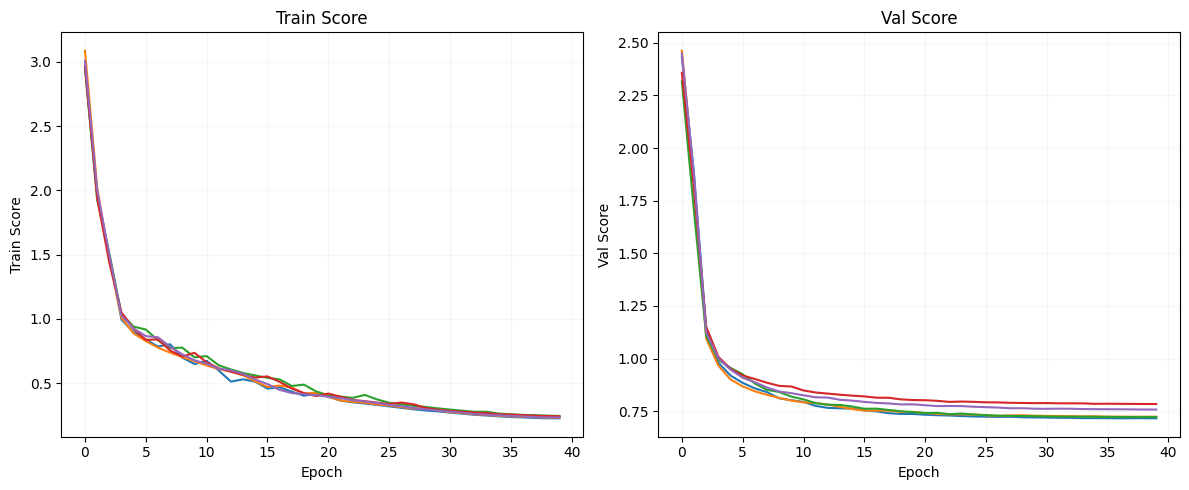

In [21]:
main()

# inference

In [22]:
class EnsembleModel:
    def __init__(self):
        self.models = []

    def __call__(self, x):
        outputs = []
        for model in self.models:
            if CFG.objective_cv == 'binary':
                outputs.append(torch.sigmoid(model(x)).to('cpu').numpy())
            elif CFG.objective_cv == 'multiclass':
                outputs.append(torch.softmax(
                    model(x), axis=1).to('cpu').numpy())
            elif CFG.objective_cv == 'regression':
                outputs.append(model(x).to('cpu').numpy())

        avg_preds = np.mean(outputs, axis=0)
        return avg_preds

    def add_model(self, model):
        self.models.append(model)


def test_fn(valid_loader, model, device):
    preds = []

    for step, (images) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)

        with torch.no_grad():
            y_preds = model(images)

        preds.append(y_preds)

    predictions = np.concatenate(preds)
    return predictions


def inference():
    test = pd.read_csv(CFG.comp_dataset_path +
                       'test_features.csv')

    test['base_path'] = CFG.comp_dataset_path + 'images/' + test['ID'] + '/'

    paths = []
    for base_path in test['base_path'].values:
        suffixs = ['image_t-1.0.png', 'image_t-0.5.png', 'image_t.png']
        for suffix in suffixs:
            path = base_path + suffix
            paths.append(path)

    print(paths[:5])

    CFG.video_cache = make_video_cache(paths)

    print(test.head(5))

    valid_dataset = CustomDataset(
        test, CFG, transform=get_transforms(data='valid', cfg=CFG))
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    model = EnsembleModel()
    folds = [0] if CFG.use_holdout else list(range(CFG.n_fold))
    for fold in folds:
        _model = CustomModel(CFG, pretrained=False)
        _model.to(device)

        model_path = CFG.model_dir + \
            f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth'
        print('load', model_path)
        state = torch.load(model_path)['model']
        _model.load_state_dict(state)
        _model.eval()

        # _model = tta.ClassificationTTAWrapper(
        #     _model, tta.aliases.five_crop_transform(256, 256))

        model.add_model(_model)

    preds = test_fn(valid_loader, model, device)

    test[CFG.target_col] = preds
    test.to_csv(CFG.submission_dir +
                'submission_oof.csv', index=False)
    test[CFG.target_col].to_csv(
        CFG.submission_dir + f'submission_{CFG.exp_name}.csv', index=False)

In [23]:
inference()

['../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t-1.0.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t-0.5.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_120/image_t.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_220/image_t-1.0.png', '../raw/atmacup_18_dataset/images/012baccc145d400c896cb82065a93d42_220/image_t-0.5.png']
[255, 227, 199, 170, 142, 114, 85, 57, 29]


0it [00:00, ?it/s]

                                     ID      vEgo      aEgo  steeringAngleDeg  \
0  012baccc145d400c896cb82065a93d42_120  3.374273 -0.019360        -34.008415   
1  012baccc145d400c896cb82065a93d42_220  2.441048 -0.022754        307.860077   
2  012baccc145d400c896cb82065a93d42_320  3.604152 -0.286239         10.774388   
3  012baccc145d400c896cb82065a93d42_420  2.048902 -0.537628         61.045235   
4  01d738e799d260a10f6324f78023b38f_120  2.201528 -1.898600          5.740093   

   steeringTorque  brake  brakePressed  gas  gasPressed gearShifter  \
0            17.0    0.0         False  0.0       False       drive   
1           295.0    0.0          True  0.0       False       drive   
2          -110.0    0.0          True  0.0       False       drive   
3           189.0    0.0          True  0.0       False       drive   
4           -41.0    0.0          True  0.0       False       drive   

   leftBlinker  rightBlinker  \
0        False         False   
1        False        

/tmp/ipykernel_94354/610043316.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(model_path)['model']


load ../proc/baseline/outputs/atmacup_18_cnn_swin_tiny/atmacup_18-models/swin_tiny_patch4_window7_224_fold1_last.pth
pretrained: False
load ../proc/baseline/outputs/atmacup_18_cnn_swin_tiny/atmacup_18-models/swin_tiny_patch4_window7_224_fold2_last.pth
pretrained: False
load ../proc/baseline/outputs/atmacup_18_cnn_swin_tiny/atmacup_18-models/swin_tiny_patch4_window7_224_fold3_last.pth
pretrained: False
load ../proc/baseline/outputs/atmacup_18_cnn_swin_tiny/atmacup_18-models/swin_tiny_patch4_window7_224_fold4_last.pth


  0%|          | 0/14 [00:00<?, ?it/s]